# Using a different random seed from the first version

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import dataclasses as dt

In [6]:
import os
import shutil
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline34IDC.optimization.common as opt_common
import aps.ai.autoalignment.beamline34IDC.optimization.configs as configs
import aps.ai.autoalignment.beamline34IDC.optimization.movers as movers
import joblib
import matplotlib.pyplot as plt
import numpy as np
import optuna
#from aps.ai.autoalignment.beamline34IDC.facade.focusing_optics_factory import (
#    ExecutionMode,
#    focusing_optics_factory_method,
#)

from aps.ai.autoalignment.beamline34IDC.facade.focusing_optics_factory import (
    ExecutionMode,
    focusing_optics_factory_method,
)
from aps.ai.autoalignment.beamline34IDC.optimization.optuna_botorch import OptunaOptimizer
from aps.ai.autoalignment.beamline34IDC.simulation.facade.focusing_optics_interface import get_default_input_features
from aps.ai.autoalignment.common.simulation.facade.parameters import Implementors
from aps.ai.autoalignment.common.util import clean_up
from aps.ai.autoalignment.common.util.common import AspectRatio, ColorMap, PlotMode
from aps.ai.autoalignment.common.util.shadow.common import (
    EmptyBeamException,
    HybridFailureException,
    PreProcessorFiles,
    load_shadow_beam,
)
from aps.ai.autoalignment.common.util.wrappers import load_beam

import aps.ai.autoalignment.beamline34IDC.optimization.analysis_utils as analysis
import aps.ai.autoalignment.beamline34IDC.optimization.analysis_plot_utils as apu
from datetime import datetime
import joblib
import matplotlib as mpl
import cmasher as cm
import colorcet as cc

from epics import ca
ca.finalize_libca()

%matplotlib inline

In [7]:
mpl.rcParams.update({'font.size': 16, 'text.usetex':True})

In [8]:
DEFAULT_RANDOM_SEED = 100

In [9]:
class OptimizationParameters:
    def __init__(self):
        self.move_motors_ranges = configs.DEFAULT_MOVEMENT_RANGES

        self.params = {
            "sum_intensity_soft_constraint": 6e3,
            "sum_intensity_hard_constraint": 6e3,
            #            "centroid_sigma_loss_threshold_dependency": CentroidSigmaLossThresholdDependency.FULLY_DYNAMIC,
            #            "centroid_sigma_loss_hard_thresholds": [0.01, 0.03],
            "loss_parameters": ["fwhm", "peak_distance"],
            "multi_objective_optimization": True,
            "n_pitch_trans_motor_trials": 50,
            "n_all_motor_trials": 100,
            "moo_thresholds": {"fwhm":0.02}
        }

In [10]:
def setup_work_dir():
    root_dir = Path(aps.__path__[0]).parents[0]
    work_dir = root_dir / "work_directory/34-ID"
    os.chdir(work_dir)

In [11]:
def print_beam_attributes(loss_parameters, hist, dw, title):
    loss_dw_functions = {
        "peak_distance": opt_common._get_peak_distance_from_dw,
        "centroid": opt_common._get_centroid_distance_from_dw,
        "sigma": opt_common._get_sigma_from_dw,
        "fwhm": opt_common._get_fwhm_from_dw,
        "negative_log_peak_intensity": lambda d: -np.log(opt_common._get_peak_intensity_from_dw(d))
    }
    loss_hist_functions = {
        "log_weighted_sum_intensity": lambda hist: np.log(opt_common._get_weighted_sum_intensity_from_hist(hist, 2))
    }

    attribs = {}
    for ltype in loss_parameters:
        if ltype in loss_dw_functions:
            loss = loss_dw_functions[ltype](dw)
        if ltype in loss_hist_functions:
            loss = loss_hist_functions[ltype](hist)
        attribs[ltype] = loss
        print(f"{title} system {ltype}: {loss:4.3e}")
    return attribs

In experiments, the perturbed max is about 400 times higher than the noise level. This seems to hold in sim with noise level 0.5

In [12]:
2560 * 0.65 * 1e-3

1.6640000000000001

In [13]:
detector_x = 0.05
detector_y = 0.05
cp = opt_common.CalculationParameters(
    xrange= [-detector_x / 2, detector_x / 2],
    yrange = [-detector_y / 2, detector_y / 2],
    nbins_h = 1024,
    nbins_v = 1024,
    use_denoised = False,
    random_seed = DEFAULT_RANDOM_SEED,
    add_noise = False,
    calculate_over_noise= False,
    implementor=Implementors.SHADOW,
    percentage_fluctuation=50,
    noise=0.5,
    save_images=True,
    every_n_images=1
   )

xrange_plot = [-0.02, 0.02]
yrange_plot = [-0.02, 0.02]

ppm = opt_common.PlotParameters(xrange=xrange_plot, yrange=yrange_plot, nbins_h = cp.nbins_h // 2, nbins_v = cp.nbins_v // 2)


In [14]:
cur_dir = Path.cwd().resolve()
save_dir = cur_dir / f'nf_fwhm_pl_pi_{DEFAULT_RANDOM_SEED}'
save_dir.mkdir(exist_ok=True)

In [15]:
setup_work_dir()
clean_up()

print(cp)

CalculationParameters(execution_mode=0, implementor=0, xrange=[-0.025, 0.025], yrange=[-0.025, 0.025], nbins_h=1024, nbins_v=1024, do_gaussian_fit=False, use_denoised=False, from_raw_image=True, random_seed=100, add_noise=False, noise=0.5, percentage_fluctuation=50, calculate_over_noise=False, noise_threshold=1.5, reference_h=0.0, reference_v=0.0, save_images=True, every_n_images=1, rng=Generator(PCG64) at 0x7FBFE99489E0)


In [16]:
ppm

PlotParameters(implementor=0, title='X,Z', xrange=[-0.02, 0.02], yrange=[-0.02, 0.02], nbins_h=512, nbins_v=512, plot_mode=0, aspect_ratio=0, color_map=<matplotlib.colors.ListedColormap object at 0x7fbfe95fcdf0>)

In [17]:
opt_params = OptimizationParameters()

print("Motors and movement ranges")
print(opt_params.move_motors_ranges)

print("Optimization parameters")
print(opt_params.params)

Motors and movement ranges
{'hb_trans': [-20, 20], 'vb_trans': [-20, 20], 'hb_pitch': [-0.02, 0.02], 'vb_pitch': [-0.02, 0.02], 'hb_1': [-30, 30], 'hb_2': [-30, 30], 'vb_1': [-30, 30], 'vb_2': [-30, 30]}
Optimization parameters
{'sum_intensity_soft_constraint': 6000.0, 'sum_intensity_hard_constraint': 6000.0, 'loss_parameters': ['fwhm', 'peak_distance'], 'multi_objective_optimization': True, 'n_pitch_trans_motor_trials': 50, 'n_all_motor_trials': 100, 'moo_thresholds': {'fwhm': 0.02}}


In [18]:
input_beam_path = "primary_optics_system_beam.dat"

clean_up()

# Initializing the focused beam from simulation
input_features = get_default_input_features()
input_beam = load_shadow_beam(input_beam_path)
focusing_system = focusing_optics_factory_method(
    execution_mode=ExecutionMode.SIMULATION,
    implementor=Implementors.SHADOW,
    bender=1,
)

focusing_system.initialize(
    input_photon_beam=input_beam,
    rewrite_preprocessor_files=PreProcessorFiles.NO,
    #layout=Layout.AUTO_FOCUSING,
    input_features=input_features,
)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


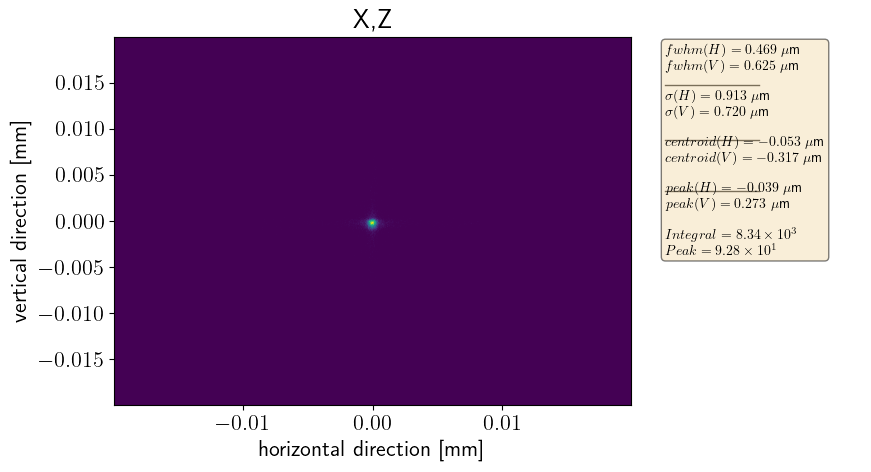

In [19]:
beam, hist, dw = opt_common.get_beam_hist_dw(cp=cp,focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(photon_beam=beam, ppm=ppm)

In [20]:
dw.__dict__

{'_DictionaryWrapper__dictionary': {'h_sigma': 0.0009130868109133654,
  'h_fwhm': 0.0004882812500000416,
  'h_centroid': -5.321893208029576e-05,
  'h_peak': -0.00017089843749999896,
  'v_sigma': 0.0007190818058053032,
  'v_fwhm': 0.0006347656250000541,
  'v_centroid': -0.000316282526630102,
  'v_peak': 0.00017089843749999896,
  'integral_intensity': 8337.699808233509,
  'peak_intensity': 42.02296407315635,
  'gaussian_fit': {}}}

In [21]:
save_dir

PosixPath('/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/jupyter/sims_for_paper/beamline34/nf_fwhm_pl_pi_100')

In [22]:
focused_beam = {'dw': dw, 'hist': hist}
joblib.dump(focused_beam, f'{save_dir}/focused_beam.joblib', compress=5)

['/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/jupyter/sims_for_paper/beamline34/nf_fwhm_pl_pi_100/focused_beam.joblib']

In [23]:
!pwd

/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID


In [24]:
m2 = apu.CMAP

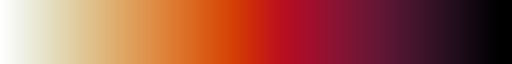

In [25]:
m2

In [26]:
maxcount = hist.data_2D.max()

In [27]:
maxcount

42.02296407315635

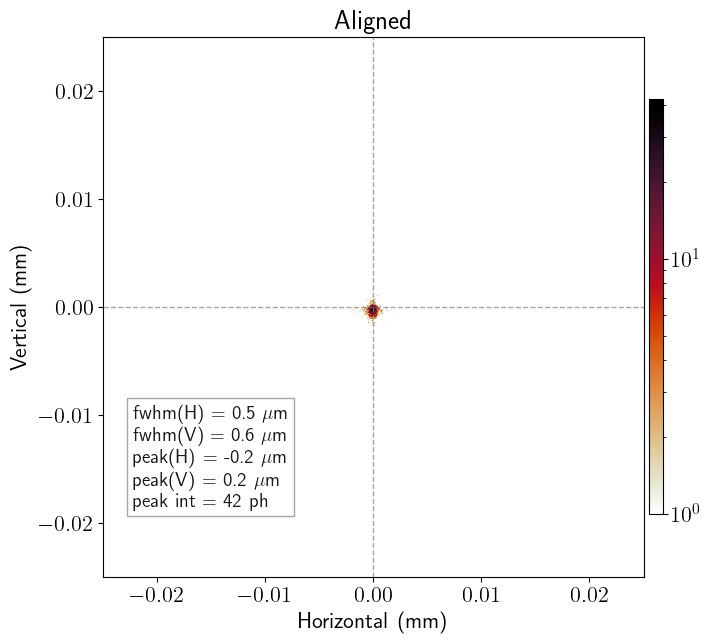

In [28]:
dwd = dw._DictionaryWrapper__dictionary

plt.figure(figsize=[7,7], constrained_layout=True)


plt.pcolormesh(hist.hh, hist.vv, hist.data_2D.T, cmap=m2, norm=mpl.colors.LogNorm(1, maxcount))
#plt.xlim(-0.025,0.025)
#plt.ylim(-0.025,0.025)
plt.axhline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.axvline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.xlabel('Horizontal (mm)')
plt.ylabel('Vertical (mm)')
plt.title("Aligned")
plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

ax = plt.gca()
ax.set_aspect('equal')

text = (fr"{'fwhm(H)':<6} = {dwd['h_fwhm'] * 1000: 3.1f} $\mu$m" + "\n"
             fr"{'fwhm(V)':<9} = {dwd['v_fwhm']* 1000: 3.1f} $\mu$m" + "\n"
             fr"{'peak(H)':<9} = {dwd['h_peak']* 1000: 3.1f} $\mu$m" + "\n"
             fr"{'peak(V)':<9} = {dwd['v_peak']* 1000: 3.1f} $\mu$m" + "\n"
             fr"{'peak int':<9} = {dwd['peak_intensity']:3.0f} ph")
ax.text(0.055, 0.13, text, color='black', alpha=0.9, fontsize=14,
        bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7), transform=ax.transAxes)
plt.show()

(-0.02, 0.02)

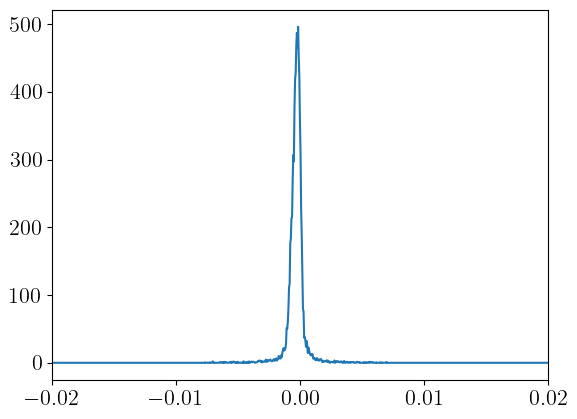

In [29]:
plt.plot(hist.hh, hist.data_2D.sum(axis=0))
plt.xlim([-0.02,0.02])

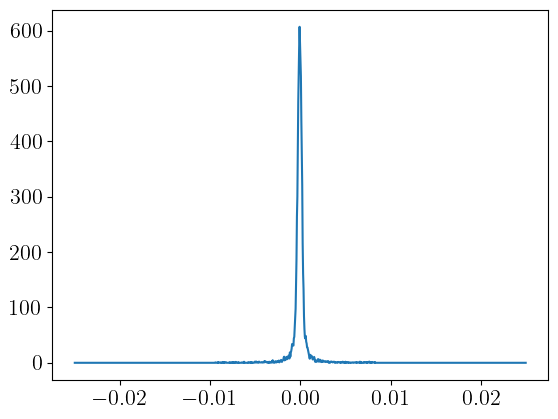

In [30]:
plt.plot(hist.vv, hist.data_2D.sum(axis=1))

In [31]:
(hist.data_2D.sum(axis=1).max() + hist.data_2D.sum(axis=0).max()) / 2

551.4994515768242

In [32]:
attribs_focus = print_beam_attributes(opt_params.params['loss_parameters'], hist, dw, "Focused beam")

Focused beam system fwhm: 8.008e-04
Focused beam system peak_distance: 2.417e-04


In [33]:
mots = list(opt_params.move_motors_ranges.keys())
initial_absolute_positions = {k: movers.get_absolute_positions(focusing_system, k)[0] for k in mots}
print("Focused absolute position are", initial_absolute_positions)



Focused absolute position are {'hb_trans': 0.0, 'vb_trans': 0.0, 'hb_pitch': 3.0000000000000506, 'vb_pitch': 3.0000000000000506, 'hb_1': 215.5, 'hb_2': 112.50000000000001, 'vb_1': 143.99999999999997, 'vb_2': 231.5}


In [34]:
random_move_ranges = {k: np.array(v) * 0.5 for k,v in opt_params.move_motors_ranges.items()}
random_move_ranges

{'hb_trans': array([-10.,  10.]),
 'vb_trans': array([-10.,  10.]),
 'hb_pitch': array([-0.01,  0.01]),
 'vb_pitch': array([-0.01,  0.01]),
 'hb_1': array([-15.,  15.]),
 'hb_2': array([-15.,  15.]),
 'vb_1': array([-15.,  15.]),
 'vb_2': array([-15.,  15.])}

In [35]:
# Adding random perturbation to the motor values
initial_movement, focusing_system, (beam_init, hist_init, dw_init) = opt_common.get_random_init(
    focusing_system=focusing_system,
    motor_types_and_ranges=random_move_ranges,
    intensity_sum_threshold=opt_params.params["sum_intensity_hard_constraint"],
    cp=cp,
    
)

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.
Random initialization is (ABSOLUTE) ['hb_trans', 'vb_trans', 'hb_pitch', 'vb_pitch', 'hb_1', 'hb_2', 'vb_1', 'vb_2'] [6.703902395933043, 1.9027714668116247, 2.996509341496062, 2.991273353740079, 229.70960000000002, 115.39420000000001, 152.7078999999999, 243.81019999999995]
Random initialization is (RELATIVE) ['hb_trans', 'vb_trans', 'hb_pitch', 'vb_pitch', 'hb_1', 'hb_2', '

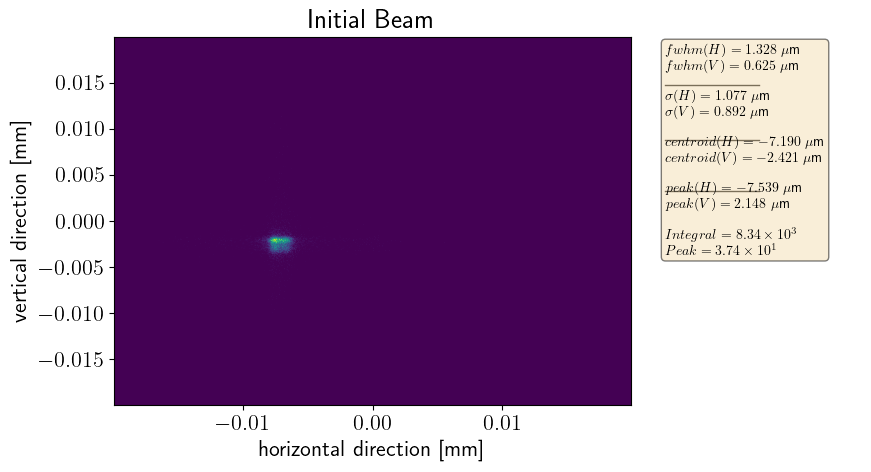

Perturbed beam system fwhm: 1.529e-03
Perturbed beam system peak_distance: 7.355e-03


In [36]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert, ppm=ppm,
    title="Initial Beam",
)
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

In [37]:
hist_pert.data_2D.max()

19.30120081968462

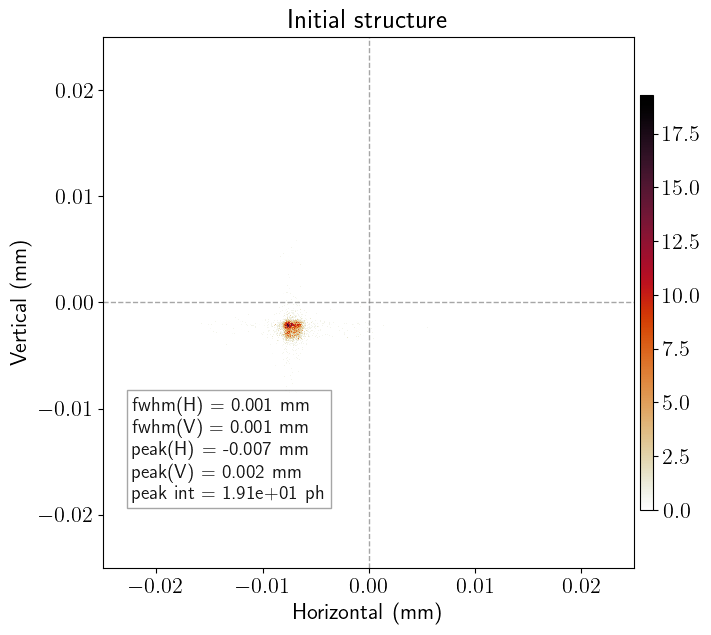

In [38]:
dwd = dw_pert._DictionaryWrapper__dictionary
plt.figure(figsize=[7,7], constrained_layout=True)
plt.pcolormesh(hist_pert.hh, hist_pert.vv, hist_pert.data_2D.T, cmap=m2)#, norm=mpl.colors.LogNorm(1, 4e2))
#plt.xlim(-0.05,0.05)
#plt.ylim(-0.05,0.05)
plt.axhline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.axvline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.xlabel('Horizontal (mm)')
plt.ylabel('Vertical (mm)')
plt.title("Initial structure")
plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

ax = plt.gca()
ax.set_aspect('equal')

text = (f"{'fwhm(H)':<6} = {dwd['h_fwhm']: 4.3f} mm\n"
             f"{'fwhm(V)':<9} = {dwd['v_fwhm']: 4.3f} mm\n"
             f"{'peak(H)':<9} = {dwd['h_peak']: 4.3f} mm\n"
             f"{'peak(V)':<9} = {dwd['v_peak']: 4.3f} mm\n"
             f"{'peak int':<9} = {dwd['peak_intensity']: 3.2e} ph")
ax.text(0.055, 0.13, text, color='black', alpha=0.9, fontsize=14,
        bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7), transform=ax.transAxes)
plt.show()

In [39]:
perturbed_positions = initial_movement + np.array(list(initial_absolute_positions.values()))

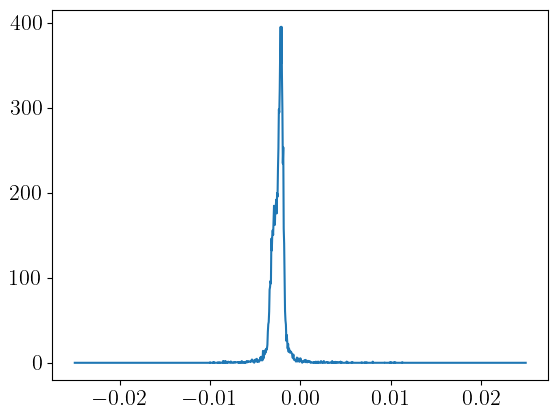

In [40]:
plt.plot(hist_pert.hh, hist_pert.data_2D.sum(axis=0))
#plt.xlim([-0.02,0.02])

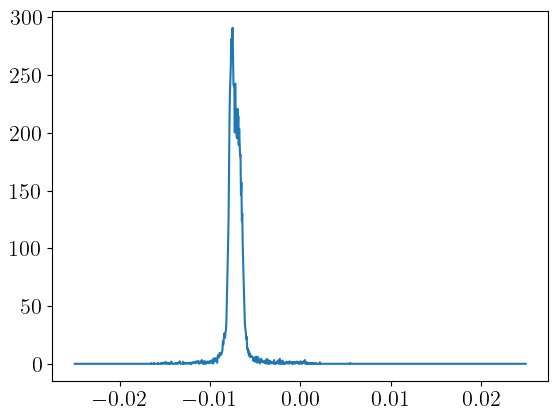

In [41]:
plt.plot(hist_pert.vv, hist_pert.data_2D.sum(axis=1))

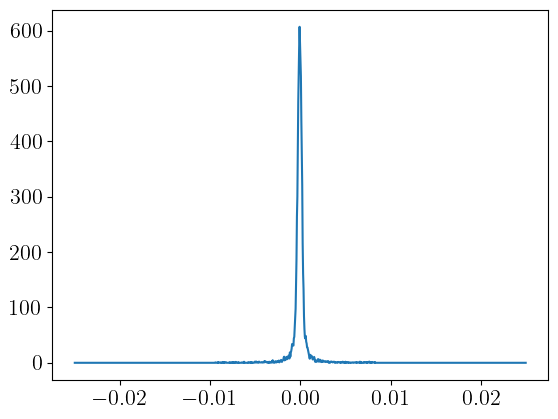

In [42]:
plt.plot(hist.vv, hist.data_2D.sum(axis=1))

In [43]:
hist.data_2D.sum()

8337.699808233509

#### Calculating without removing noise : two step optimization

In [44]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement='absolute')

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.


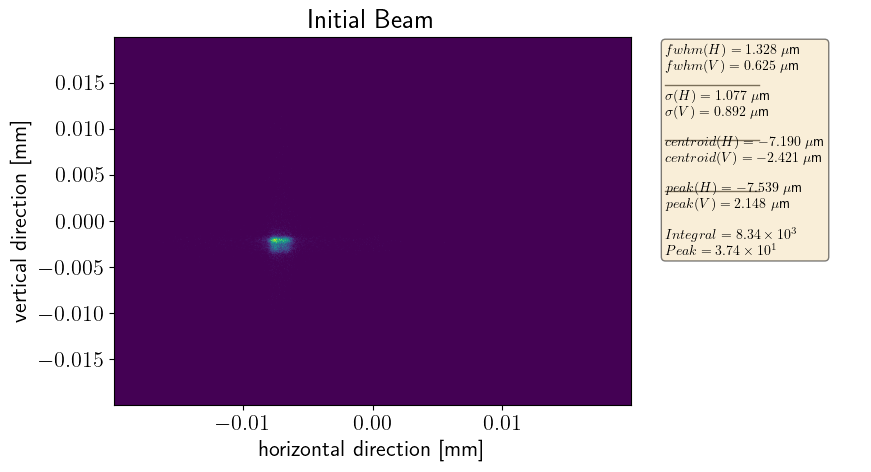

In [45]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert,
    title="Initial Beam",
    ppm=ppm
)

In [46]:
hist_pert.data_2D.max()

19.30120081968449

In [47]:
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

Perturbed beam system fwhm: 1.529e-03
Perturbed beam system peak_distance: 7.355e-03


In [48]:
opt_params = OptimizationParameters()

In [49]:
from importlib import reload

In [50]:
import aps.ai.autoalignment.beamline34IDC.optimization.optuna_botorch as opter

In [51]:
# Now the optimization
opt_trial = opter.OptunaOptimizer(calculation_parameters=cp,
    focusing_system=focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    dump_directory=save_dir
    )

In [52]:
moo_thresholds = opt_params.params["moo_thresholds"]
for ltype in opt_params.params["loss_parameters"]:
    if ltype not in moo_thresholds:
        moo_thresholds[ltype] = opt_trial.get_beam_property_function_for_loss(ltype)()

In [53]:
attribs_init

{'fwhm': 0.0015285620939941272, 'peak_distance': 0.007354510925131322}

In [54]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}#, "peak_distance": attribs_init["peak_distance"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=moo_thresholds
)

[I 2023-07-04 22:59:01,481] A new study created in memory with name: no-name-39476e0b-841d-4517-8768-691c520ba835


In [55]:
opt_trial.trials(50, trial_motor_types=['hb_pitch', 'hb_trans', 'vb_pitch', 'vb_trans'])

/Users/skandel/code/oasys/AI-ML_Control_System/aps/ai/autoalignment/beamline34IDC/optimization/optuna_botorch.py:316: ExperimentalWarning: PartialFixedSampler is experimental (supported from v2.4.0). The interface can change in the future.
  partial_sampler = optuna.samplers.PartialFixedSampler(fixed_params, self._base_sampler)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:653: UserWarning: Fixed parameter 'hb_pitch' with value 0.0 is out of range for distribution FloatDistribution(high=0.0185, log=False, low=-0.02, step=0.00175).
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Py

Pruning trial with parameters [-12.6, -15.7, -0.01125, 0.0185, 0.0, 0.0, 0.0, 0.0]


[I 2023-07-04 22:59:55,377] Trial 5 pruned. 


Pruning trial with parameters [12.399999999999999, -13.2, 0.0115, -0.0095, 0.0, 0.0, 0.0, 0.0]


[I 2023-07-04 23:00:04,539] Trial 6 pruned. 


Pruning trial with parameters [-2.8000000000000007, 17.6, 0.0115, -0.00775, 0.0, 0.0, 0.0, 0.0]


[I 2023-07-04 23:00:16,070] Trial 7 finished with values: [0.0008638577154763496, 0.012002833111428553] and parameters: {'hb_trans': -13.0, 'vb_trans': -5.1, 'hb_pitch': -0.02, 'vb_pitch': -0.01125, 'hb_1': 0.0, 'hb_2': 0.0, 'vb_1': 0.0, 'vb_2': 0.0}. 
[I 2023-07-04 23:00:23,793] Trial 8 pruned. 


Pruning trial with parameters [11.8, -19.4, 0.002749999999999999, 0.002749999999999999, 0.0, 0.0, 0.0, 0.0]


[I 2023-07-04 23:00:33,819] Trial 9 finished with values: [0.0010160474632171185, 0.003891114476065273] and parameters: {'hb_trans': -15.8, 'vb_trans': -4.799999999999999, 'hb_pitch': -0.02, 'vb_pitch': 0.015000000000000003, 'hb_1': 0.0, 'hb_2': 0.0, 'vb_1': 0.0, 'vb_2': 0.0}. 
[I 2023-07-04 23:00:42,048] Trial 10 pruned. 


Pruning trial with parameters [19.200000000000003, -17.7, 0.015000000000000003, 0.002749999999999999, 0.0, 0.0, 0.0, 0.0]


[I 2023-07-04 23:00:52,774] Trial 11 finished with values: [0.012229471561373191, 0.01592684071441075] and parameters: {'hb_trans': 9.600000000000001, 'vb_trans': 5.200000000000003, 'hb_pitch': 0.002749999999999999, 'vb_pitch': -0.02, 'hb_1': 0.0, 'hb_2': 0.0, 'vb_1': 0.0, 'vb_2': 0.0}. 
[I 2023-07-04 23:01:02,474] Trial 12 finished with values: [0.0010841603179285357, 0.008262564252871921] and parameters: {'hb_trans': -11.6, 'vb_trans': 1.7000000000000028, 'hb_pitch': 0.009750000000000002, 'vb_pitch': -0.01125, 'hb_1': 0.0, 'hb_2': 0.0, 'vb_1': 0.0, 'vb_2': 0.0}. 
[I 2023-07-04 23:01:11,396] Trial 13 finished with values: [0.0018347943582087438, 0.01983711311910139] and parameters: {'hb_trans': -8.6, 'vb_trans': 14.0, 'hb_pitch': 0.0185, 'vb_pitch': 0.015000000000000003, 'hb_1': 0.0, 'hb_2': 0.0, 'vb_1': 0.0, 'vb_2': 0.0}. 
[I 2023-07-04 23:01:21,111] Trial 14 finished with values: [0.0014566829970876535, 0.003614105955292278] and parameters: {'hb_trans': -5.699999999999999, 'vb_trans

Pruning trial with parameters [-17.6, -4.199999999999999, -0.01825, 0.0115, 0.0, 0.0, 0.0, 0.0]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(
[I 2023-07-04 23:02:32,976] Trial 20 pruned. 


Pruning trial with parameters [-18.6, -7.1, -0.02, 0.008, 0.0, 0.0, 0.0, 0.0]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(
[I 2023-07-04 23:02:45,873] Trial 21 pruned. 


Pruning trial with parameters [-17.7, -0.5, -0.0165, 0.006249999999999999, 0.0, 0.0, 0.0, 0.0]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(
[I 2023-07-04 23:02:58,805] Trial 22 pruned. 


Pruning trial with parameters [-18.8, -7.299999999999999, -0.01475, 0.008, 0.0, 0.0, 0.0, 0.0]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(
[I 2023-07-04 23:03:12,136] Trial 23 pruned. 


Pruning trial with parameters [-17.5, -3.6999999999999993, -0.0165, 0.008, 0.0, 0.0, 0.0, 0.0]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(
[I 2023-07-04 23:03:24,966] Trial 24 pruned. 


Pruning trial with parameters [-19.2, -1.8999999999999986, -0.0165, 0.013250000000000001, 0.0, 0.0, 0.0, 0.0]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(
[I 2023-07-04 23:03:38,464] Trial 25 pruned. 


Pruning trial with parameters [-19.3, -7.799999999999999, -0.01825, 0.008, 0.0, 0.0, 0.0, 0.0]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(
[I 2023-07-04 23:03:51,239] Trial 26 finished with values: [0.0007

Pruning trial with parameters [-19.1, -0.8999999999999986, -0.01475, 0.016749999999999998, 0.0, 0.0, 0.0, 0.0]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(
[I 2023-07-04 23:04:18,667] Trial 28 finished with values: [0.0008

Pruning trial with parameters [-17.6, -7.699999999999999, -0.01475, 0.0115, 0.0, 0.0, 0.0, 0.0]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(
[I 2023-07-04 23:05:15,904] Trial 32 pruned. 


Pruning trial with parameters [-18.8, -9.299999999999999, -0.02, 0.0115, 0.0, 0.0, 0.0, 0.0]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(
[I 2023-07-04 23:05:32,027] Trial 33 pruned. 


Pruning trial with parameters [-19.9, -10.2, -0.0165, 0.0185, 0.0, 0.0, 0.0, 0.0]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(
[I 2023-07-04 23:05:47,695] Trial 34 pruned. 


Pruning trial with parameters [-19.3, -12.3, -0.01825, 0.013250000000000001, 0.0, 0.0, 0.0, 0.0]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(
[I 2023-07-04 23:06:03,671] Trial 35 pruned. 


Pruning trial with parameters [-17.0, -9.299999999999999, -0.01825, 0.015000000000000003, 0.0, 0.0, 0.0, 0.0]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(
[I 2023-07-04 23:06:18,902] Trial 36 pruned. 


Pruning trial with parameters [-16.8, -12.6, -0.01825, 0.008, 0.0, 0.0, 0.0, 0.0]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(
[I 2023-07-04 23:06:34,202] Trial 37 pruned. 


Pruning trial with parameters [-17.9, -3.099999999999998, -0.013000000000000001, 0.015000000000000003, 0.0, 0.0, 0.0, 0.0]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(
[I 2023-07-04 23:06:48,735] Trial 38 pruned. 


Pruning trial with parameters [-16.7, -14.8, -0.01475, 0.013250000000000001, 0.0, 0.0, 0.0, 0.0]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(
[I 2023-07-04 23:07:03,084] Trial 39 pruned. 


Pruning trial with parameters [-17.6, -7.0, -0.01475, 0.013250000000000001, 0.0, 0.0, 0.0, 0.0]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(
[I 2023-07-04 23:07:17,767] Trial 40 finished with values: [0.0008

Pruning trial with parameters [-17.4, -1.6999999999999993, -0.01475, 0.0185, 0.0, 0.0, 0.0, 0.0]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(
[I 2023-07-04 23:08:15,146] Trial 44 finished with values: [0.0009

In [56]:
opt_trial.trials(75)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:09:48,277] Trial 50 finished with values: [0.0013147375017419343, 0.004081896912038898] and parameters: {'hb_trans': -10.799999999999999, 'vb_trans': -3.8000000000000007, 'hb_pitch': 0.002749999999999999, 'vb_pitch': 0.0115, 'hb_1': -8.129099999999998, 'hb_2': 8.1631, 'vb_1': -6.305999999999997, 'vb_2': -10.840499999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:10:02,880] Trial 51 finished with values: [0.0009379576519677824, 0.0027153442799607978] and parameters: {'hb_trans': -9.7, 'vb_trans': 0.40000000000000213, 'hb_pitch': -0.02, 'vb_pitch': 0.002749999999999999, 'hb_1': -15.892199999999999, 'hb_2': 0.428600000000003, 'vb_1': -11.2227, 'vb_2': 8.6267}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Vers

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:10:16,235] Trial 52 finished with values: [0.0011759369705852854, 0.0014422905749747975] and parameters: {'hb_trans': -12.1, 'vb_trans': -8.299999999999999, 'hb_pitch': -0.01825, 'vb_pitch': 0.0185, 'hb_1': -12.852899999999998, 'hb_2': 4.733699999999999, 'vb_1': 2.0243000000000038, 'vb_2': 4.379200000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:10:28,306] Trial 53 finished with values: [0.027988100656912773, 0.0013323011376603776] and parameters: {'hb_trans': -15.1, 'vb_trans': -2.5, 'hb_pitch': -0.0095, 'vb_pitch': 0.013250000000000001, 'hb_1': -16.520899999999997, 'hb_2': -8.402099999999997, 'vb_1': 3.358400000000003, 'vb_2': -8.733799999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:10:39,987] Trial 54 finished with values: [0.0008802615418614006, 0.021079305718948515] and parameters: {'hb_trans': -17.9, 'vb_trans': 2.3000000000000007, 'hb_pitch': -0.00425, 'vb_pitch': 0.0045000000000000005, 'hb_1': -11.585899999999999, 'hb_2': 1.7359000000000009, 'vb_1': 12.860199999999999, 'vb_2': -1.2175999999999974}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:10:50,805] Trial 55 finished with values: [0.017209957363292318, 0.005213074115998313] and parameters: {'hb_trans': -19.3, 'vb_trans': 3.400000000000002, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': -0.00775, 'hb_1': -9.7103, 'hb_2': 6.302, 'vb_1': -5.217599999999997, 'vb_2': -0.7835999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ver

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:11:03,817] Trial 56 finished with values: [0.0010841603179285357, 0.005887485466876386] and parameters: {'hb_trans': -9.299999999999999, 'vb_trans': -0.6999999999999993, 'hb_pitch': 0.013250000000000001, 'vb_pitch': -0.0007500000000000007, 'hb_1': -17.2377, 'hb_2': 5.8444, 'vb_1': -6.895199999999999, 'vb_2': -17.3689}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/P

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:11:16,343] Trial 57 finished with values: [0.0009667475524035654, 0.0037886660653598868] and parameters: {'hb_trans': -9.6, 'vb_trans': -5.899999999999999, 'hb_pitch': -0.01475, 'vb_pitch': 0.009750000000000002, 'hb_1': -21.247, 'hb_2': 7.8872, 'vb_1': -7.4358, 'vb_2': -11.325}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:11:27,577] Trial 58 finished with values: [0.0013192632896589305, 0.009809775684992403] and parameters: {'hb_trans': -11.5, 'vb_trans': -0.29999999999999716, 'hb_pitch': -0.00425, 'vb_pitch': -0.01475, 'hb_1': -16.918, 'hb_2': 8.785000000000004, 'vb_1': -3.2545, 'vb_2': -15.2998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:11:38,382] Trial 59 finished with values: [0.002103580002787095, 0.003558930599881165] and parameters: {'hb_trans': -4.799999999999999, 'vb_trans': -3.6999999999999993, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': 0.0185, 'hb_1': -8.939, 'hb_2': 4.435500000000005, 'vb_1': 2.1051, 'vb_2': 9.252900000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:11:49,585] Trial 60 finished with values: [0.0013327484437458345, 0.0010363762342183167] and parameters: {'hb_trans': -10.0, 'vb_trans': -3.8999999999999986, 'hb_pitch': -0.013000000000000001, 'vb_pitch': 0.013250000000000001, 'hb_1': -13.006599999999999, 'hb_2': 1.5139000000000031, 'vb_1': -0.23279999999999745, 'vb_2': 4.618700000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:12:00,405] Trial 61 finished with values: [0.0009003461384075852, 0.004049644671264502] and parameters: {'hb_trans': -7.5, 'vb_trans': 7.0, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': -0.0024999999999999988, 'hb_1': -5.976099999999999, 'hb_2': -2.117099999999997, 'vb_1': -11.6909, 'vb_2': 6.6163000000000025}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:12:11,368] Trial 62 finished with values: [0.0010841603179285357, 0.004411452880759926] and parameters: {'hb_trans': -7.1, 'vb_trans': -2.5, 'hb_pitch': -0.0095, 'vb_pitch': 0.002749999999999999, 'hb_1': -14.6624, 'hb_2': 12.1006, 'vb_1': -4.455199999999998, 'vb_2': -8.013199999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:12:22,963] Trial 63 finished with values: [0.0010381001770249567, 0.006591344747225882] and parameters: {'hb_trans': -4.5, 'vb_trans': 5.100000000000001, 'hb_pitch': -0.01475, 'vb_pitch': -0.00775, 'hb_1': -9.514699999999998, 'hb_2': 0.03410000000000224, 'vb_1': -7.394099999999998, 'vb_2': 20.048300000000005}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:12:34,958] Trial 64 finished with values: [0.0022064694390031185, 0.006373987603674937] and parameters: {'hb_trans': -5.899999999999999, 'vb_trans': 0.5, 'hb_pitch': -0.00775, 'vb_pitch': 0.015000000000000003, 'hb_1': 1.2417000000000016, 'hb_2': -0.7015999999999991, 'vb_1': -2.9678000000000004, 'vb_2': 19.624900000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewor

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:12:46,052] Trial 65 finished with values: [0.0008400708268597032, 0.005298807787407985] and parameters: {'hb_trans': -15.899999999999999, 'vb_trans': -5.699999999999999, 'hb_pitch': -0.02, 'vb_pitch': 0.008, 'hb_1': -27.808, 'hb_2': 2.5551999999999992, 'vb_1': -7.4999, 'vb_2': -6.437999999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:12:56,628] Trial 66 finished with values: [0.001441877251976041, 0.011012068370453036] and parameters: {'hb_trans': -14.1, 'vb_trans': 0.40000000000000213, 'hb_pitch': 0.0185, 'vb_pitch': 0.009750000000000002, 'hb_1': -9.3429, 'hb_2': 10.215499999999999, 'vb_1': -17.9394, 'vb_2': -18.1124}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:13:10,672] Trial 67 finished with values: [0.0015041915821045583, 0.003690482533650141] and parameters: {'hb_trans': -13.8, 'vb_trans': 3.8000000000000007, 'hb_pitch': -0.0095, 'vb_pitch': -0.0007500000000000007, 'hb_1': -5.261699999999998, 'hb_2': 8.288600000000002, 'vb_1': -6.017299999999999, 'vb_2': -29.4772}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:13:22,080] Trial 68 finished with values: [0.0009003461384075852, 0.0049753199872188845] and parameters: {'hb_trans': -15.3, 'vb_trans': -0.6999999999999993, 'hb_pitch': -0.013000000000000001, 'vb_pitch': 0.0010000000000000009, 'hb_1': 6.4129000000000005, 'hb_2': -1.6235999999999997, 'vb_1': -15.1557, 'vb_2': 14.421500000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/F

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:13:31,905] Trial 69 finished with values: [0.0008400708268597032, 0.011728562379564387] and parameters: {'hb_trans': -17.6, 'vb_trans': 5.5, 'hb_pitch': 0.002749999999999999, 'vb_pitch': 0.0010000000000000009, 'hb_1': -10.2758, 'hb_2': -0.9415999999999976, 'vb_1': -18.4913, 'vb_2': 21.1777}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:13:44,241] Trial 70 pruned. 


Pruning trial with parameters [-17.7, -7.199999999999999, -0.013000000000000001, 0.0115, -28.4308, 2.6837000000000018, 0.5934000000000026, -12.069399999999998]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:13:56,869] Trial 71 finished with values: [0.0009003461384075852, 0.003487880158299196] and parameters: {'hb_trans': -6.5, 'vb_trans': -1.6999999999999993, 'hb_pitch': -0.0095, 'vb_pitch': 0.006249999999999999, 'hb_1': 12.395500000000006, 'hb_2': 0.49370000000000047, 'vb_1': -8.231299999999997, 'vb_2': -13.5581}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:14:07,246] Trial 72 finished with values: [0.0011647324650271075, 0.0005787729292543803] and parameters: {'hb_trans': -10.5, 'vb_trans': -4.899999999999999, 'hb_pitch': -0.013000000000000001, 'vb_pitch': 0.016749999999999998, 'hb_1': -16.7136, 'hb_2': 2.9938000000000002, 'vb_1': 0.8824000000000005, 'vb_2': -12.913799999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:14:16,977] Trial 73 finished with values: [0.0007595873626028013, 0.005478441642492891] and parameters: {'hb_trans': -4.199999999999999, 'vb_trans': -3.8000000000000007, 'hb_pitch': -0.00775, 'vb_pitch': 0.0115, 'hb_1': -19.8783, 'hb_2': 5.463000000000001, 'vb_1': -10.081599999999998, 'vb_2': -19.8781}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:14:27,539] Trial 74 finished with values: [0.00193164457469279, 0.002593182605132074] and parameters: {'hb_trans': -11.6, 'vb_trans': 3.0, 'hb_pitch': -0.0095, 'vb_pitch': -0.006, 'hb_1': 2.4712999999999994, 'hb_2': 14.058100000000003, 'vb_1': -9.0256, 'vb_2': -16.2053}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-p

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:14:41,995] Trial 75 finished with values: [0.001289099490473165, 0.0062953259098443215] and parameters: {'hb_trans': -15.6, 'vb_trans': 3.3000000000000007, 'hb_pitch': -0.0165, 'vb_pitch': -0.013000000000000001, 'hb_1': -5.759699999999999, 'hb_2': -1.4404000000000003, 'vb_1': -5.337599999999998, 'vb_2': 5.425699999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewor

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:14:52,775] Trial 76 finished with values: [0.0010918300671386623, 0.0026871000480240444] and parameters: {'hb_trans': -7.6, 'vb_trans': -1.8000000000000007, 'hb_pitch': 0.009750000000000002, 'vb_pitch': 0.006249999999999999, 'hb_1': 3.2879000000000005, 'hb_2': 1.3506999999999998, 'vb_1': -3.245899999999999, 'vb_2': -3.333099999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Cont

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:15:06,775] Trial 77 finished with values: [0.0013566839833448231, 0.0035441617965276105] and parameters: {'hb_trans': -11.4, 'vb_trans': 6.0, 'hb_pitch': -0.0165, 'vb_pitch': -0.0007500000000000007, 'hb_1': -10.503699999999998, 'hb_2': 10.898700000000005, 'vb_1': -8.433899999999998, 'vb_2': -20.049}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ver

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:15:18,316] Trial 78 finished with values: [0.0010753279074974178, 0.003514438004910095] and parameters: {'hb_trans': -7.0, 'vb_trans': -2.3999999999999986, 'hb_pitch': 0.016749999999999998, 'vb_pitch': 0.0115, 'hb_1': -29.4972, 'hb_2': 3.6298999999999992, 'vb_1': -1.2576, 'vb_2': -10.2239}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:15:28,165] Trial 79 finished with values: [0.0009480706952611941, 0.007210130309515923] and parameters: {'hb_trans': -13.1, 'vb_trans': 1.5, 'hb_pitch': 0.006249999999999999, 'vb_pitch': -0.0007500000000000007, 'hb_1': -3.8751999999999995, 'hb_2': 2.451900000000002, 'vb_1': -11.3458, 'vb_2': -22.5517}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/V

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:15:41,266] Trial 80 finished with values: [0.0013192632896589305, 0.00864581893245616] and parameters: {'hb_trans': -3.5, 'vb_trans': 1.9000000000000021, 'hb_pitch': -0.01825, 'vb_pitch': 0.002749999999999999, 'hb_1': -6.643799999999999, 'hb_2': 7.771799999999999, 'vb_1': 1.9969000000000001, 'vb_2': -9.3032}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:15:52,437] Trial 81 finished with values: [0.018325189457809383, 0.007986421625117568] and parameters: {'hb_trans': 4.900000000000002, 'vb_trans': 1.4000000000000021, 'hb_pitch': 0.008, 'vb_pitch': 0.0010000000000000009, 'hb_1': -16.086599999999997, 'hb_2': 9.2939, 'vb_1': -14.6894, 'vb_2': -14.8166}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ve

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:16:04,499] Trial 82 finished with values: [0.0011523851290241164, 0.007131330522087642] and parameters: {'hb_trans': -5.6, 'vb_trans': -1.5, 'hb_pitch': -0.01475, 'vb_pitch': -0.0024999999999999988, 'hb_1': -6.689799999999998, 'hb_2': 5.558100000000003, 'vb_1': -10.625499999999999, 'vb_2': -15.7107}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ver

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:16:15,773] Trial 83 finished with values: [0.0010160474632171185, 0.001779716500840586] and parameters: {'hb_trans': -5.799999999999999, 'vb_trans': -3.1999999999999993, 'hb_pitch': 0.0115, 'vb_pitch': 0.008, 'hb_1': -25.7505, 'hb_2': 14.380200000000002, 'vb_1': -3.989799999999999, 'vb_2': -7.036899999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:16:28,891] Trial 84 finished with values: [0.001761200077819626, 0.0026621405417058546] and parameters: {'hb_trans': -8.6, 'vb_trans': -2.6999999999999993, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': 0.016749999999999998, 'hb_1': 3.049599999999998, 'hb_2': 4.2316, 'vb_1': 0.985400000000002, 'vb_2': -18.841099999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:16:38,872] Trial 85 finished with values: [0.0008693600495491393, 0.00247559075289226] and parameters: {'hb_trans': -9.1, 'vb_trans': -1.0, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': 0.002749999999999999, 'hb_1': 3.984500000000004, 'hb_2': -0.3036999999999992, 'vb_1': -13.771899999999999, 'vb_2': -19.494999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:16:47,257] Trial 86 finished with values: [0.0011357132177357422, 0.003855412599720931] and parameters: {'hb_trans': -9.2, 'vb_trans': -0.3999999999999986, 'hb_pitch': -0.00425, 'vb_pitch': 0.013250000000000001, 'hb_1': -12.494999999999997, 'hb_2': 10.887799999999999, 'vb_1': 5.454100000000004, 'vb_2': -3.1295}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.f

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:17:00,342] Trial 87 finished with values: [0.001139904055657202, 0.0030479468392169153] and parameters: {'hb_trans': -10.2, 'vb_trans': 2.900000000000002, 'hb_pitch': -0.01825, 'vb_pitch': 0.002749999999999999, 'hb_1': -23.8959, 'hb_2': 13.401600000000002, 'vb_1': -9.514899999999997, 'vb_2': 5.922200000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:17:12,629] Trial 88 finished with values: [0.0018073003440745436, 0.007027264631164187] and parameters: {'hb_trans': -8.6, 'vb_trans': -7.6, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': 0.006249999999999999, 'hb_1': -0.809899999999999, 'hb_2': 9.806400000000004, 'vb_1': -1.195999999999998, 'vb_2': -17.9964}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:17:27,325] Trial 89 finished with values: [0.0007324218750000625, 0.004905829539171455] and parameters: {'hb_trans': -6.899999999999999, 'vb_trans': -0.7999999999999972, 'hb_pitch': -0.01125, 'vb_pitch': 0.013250000000000001, 'hb_1': -12.4891, 'hb_2': 1.3689999999999998, 'vb_1': -14.915799999999999, 'vb_2': 1.4649}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pyth

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:17:37,191] Trial 90 finished with values: [0.0009480706952611941, 0.0065346736421940275] and parameters: {'hb_trans': -13.1, 'vb_trans': -1.1999999999999993, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': 0.015000000000000003, 'hb_1': -14.261899999999999, 'hb_2': 0.49260000000000304, 'vb_1': -5.278299999999998, 'vb_2': -12.453599999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:17:48,245] Trial 91 finished with values: [0.0011523851290241164, 0.0015644061858985146] and parameters: {'hb_trans': -11.4, 'vb_trans': -1.6999999999999993, 'hb_pitch': -0.01825, 'vb_pitch': 0.0045000000000000005, 'hb_1': -2.3523999999999994, 'hb_2': 3.1885000000000048, 'vb_1': -16.2277, 'vb_2': -19.57}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framewor

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:18:03,626] Trial 92 finished with values: [0.0020232763042092217, 0.003404864668208338] and parameters: {'hb_trans': -10.9, 'vb_trans': -0.09999999999999787, 'hb_pitch': -0.0165, 'vb_pitch': 0.0115, 'hb_1': 6.4543000000000035, 'hb_2': 12.438099999999999, 'vb_1': -14.9375, 'vb_2': -7.697099999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ver

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:18:16,297] Trial 93 finished with values: [0.0019610435183618083, 0.002311226571491966] and parameters: {'hb_trans': -4.0, 'vb_trans': 1.6000000000000014, 'hb_pitch': 0.008, 'vb_pitch': 0.0045000000000000005, 'hb_1': -0.02839999999999776, 'hb_2': 16.192700000000002, 'vb_1': -16.7976, 'vb_2': -19.081699999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:18:28,198] Trial 94 finished with values: [0.0015942214567691308, 0.0011965381596526214] and parameters: {'hb_trans': -10.799999999999999, 'vb_trans': -0.09999999999999787, 'hb_pitch': -0.0095, 'vb_pitch': 0.0045000000000000005, 'hb_1': -10.3247, 'hb_2': 19.373600000000003, 'vb_1': -7.659099999999999, 'vb_2': -13.5608}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:18:38,448] Trial 95 finished with values: [0.0012246031449204612, 0.0024620707491169362] and parameters: {'hb_trans': -9.299999999999999, 'vb_trans': -1.0, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': 0.008, 'hb_1': -9.6404, 'hb_2': 11.9043, 'vb_1': -9.8842, 'vb_2': 0.43510000000000204}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/l

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:18:50,666] Trial 96 finished with values: [0.0016928648265001167, 0.002872363996747204] and parameters: {'hb_trans': -5.299999999999999, 'vb_trans': 2.1000000000000014, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': -0.006, 'hb_1': 5.124000000000002, 'hb_2': -0.5976999999999997, 'vb_1': -7.117699999999999, 'vb_2': 16.6336}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:19:02,372] Trial 97 finished with values: [0.0012323661586059608, 0.0027100709085231757] and parameters: {'hb_trans': -7.0, 'vb_trans': 4.100000000000001, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': 0.0010000000000000009, 'hb_1': -14.8361, 'hb_2': 6.588300000000004, 'vb_1': 2.290300000000002, 'vb_2': -1.4568999999999974}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:19:14,252] Trial 98 finished with values: [0.0013407744353268703, 0.0028009218741937296] and parameters: {'hb_trans': -6.0, 'vb_trans': 2.0, 'hb_pitch': -0.00425, 'vb_pitch': -0.0024999999999999988, 'hb_1': -19.856099999999998, 'hb_2': 15.564, 'vb_1': -4.415799999999997, 'vb_2': 3.219000000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:19:26,704] Trial 99 finished with values: [0.002203225424351453, 0.004075466882838131] and parameters: {'hb_trans': -8.2, 'vb_trans': 3.700000000000003, 'hb_pitch': -0.013000000000000001, 'vb_pitch': 0.002749999999999999, 'hb_1': 9.2243, 'hb_2': 14.5368, 'vb_1': -10.467499999999998, 'vb_2': -6.178899999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:19:38,499] Trial 100 finished with values: [0.002229045353616074, 0.005006371253518037] and parameters: {'hb_trans': -10.9, 'vb_trans': -7.799999999999999, 'hb_pitch': -0.0165, 'vb_pitch': 0.009750000000000002, 'hb_1': -18.7042, 'hb_2': 16.1456, 'vb_1': -22.6875, 'vb_2': -17.9834}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/pytho

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:19:51,245] Trial 101 finished with values: [0.0013827931893073734, 0.0024919092866114104] and parameters: {'hb_trans': -12.899999999999999, 'vb_trans': 3.200000000000003, 'hb_pitch': -0.01475, 'vb_pitch': -0.006, 'hb_1': -29.9151, 'hb_2': 11.744500000000002, 'vb_1': -4.444399999999998, 'vb_2': -15.842699999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pytho

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:20:04,961] Trial 102 finished with values: [0.001114522676808037, 0.000989296854948965] and parameters: {'hb_trans': -12.3, 'vb_trans': 3.6000000000000014, 'hb_pitch': -0.01825, 'vb_pitch': -0.006, 'hb_1': -23.505, 'hb_2': 0.2665000000000006, 'vb_1': -5.404899999999998, 'vb_2': 2.424199999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:20:19,636] Trial 103 finished with values: [0.0015882281218058574, 0.002086795473277158] and parameters: {'hb_trans': -10.6, 'vb_trans': -1.1999999999999993, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': 0.006249999999999999, 'hb_1': -26.5187, 'hb_2': 17.5064, 'vb_1': 2.826100000000004, 'vb_2': 5.870200000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pyth

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:20:31,831] Trial 104 finished with values: [0.0023366183816418786, 0.004363633786186266] and parameters: {'hb_trans': -4.6, 'vb_trans': -4.6, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': 0.0185, 'hb_1': 5.837700000000005, 'hb_2': 18.401600000000002, 'vb_1': -13.643799999999999, 'vb_2': -1.3222999999999985}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:20:44,386] Trial 105 finished with values: [0.0019042968750001624, 0.004548753278353212] and parameters: {'hb_trans': -6.6, 'vb_trans': 0.9000000000000021, 'hb_pitch': 0.016749999999999998, 'vb_pitch': 0.008, 'hb_1': -4.082599999999999, 'hb_2': 20.5171, 'vb_1': -11.448, 'vb_2': 9.789500000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versio

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:20:57,375] Trial 106 finished with values: [0.0018689120321295186, 0.002263277086880232] and parameters: {'hb_trans': -10.2, 'vb_trans': -5.0, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': 0.013250000000000001, 'hb_1': -3.0563000000000002, 'hb_2': 16.150600000000004, 'vb_1': -0.828599999999998, 'vb_2': -6.581899999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:21:08,354] Trial 107 finished with values: [0.001769303801952635, 0.004138165589239964] and parameters: {'hb_trans': -6.799999999999999, 'vb_trans': -1.8999999999999986, 'hb_pitch': -0.006, 'vb_pitch': 0.015000000000000003, 'hb_1': -22.820999999999998, 'hb_2': 24.087700000000005, 'vb_1': -19.9022, 'vb_2': -20.952399999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:21:20,163] Trial 108 finished with values: [0.0016172358556328717, 0.004373457500470634] and parameters: {'hb_trans': -10.6, 'vb_trans': 0.3000000000000007, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': 0.002749999999999999, 'hb_1': -7.5519, 'hb_2': 14.465800000000002, 'vb_1': -4.104499999999998, 'vb_2': 0.2983000000000011}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:21:33,597] Trial 109 finished with values: [0.00217764678915817, 0.0031236645706175688] and parameters: {'hb_trans': -7.799999999999999, 'vb_trans': -2.3999999999999986, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': 0.015000000000000003, 'hb_1': -8.5945, 'hb_2': 21.485100000000003, 'vb_1': -21.4853, 'vb_2': -14.4218}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/P

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:21:46,306] Trial 110 finished with values: [0.000988694176333902, 0.005251804768207236] and parameters: {'hb_trans': -1.8999999999999986, 'vb_trans': -1.5999999999999979, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': 0.008, 'hb_1': -13.134799999999998, 'hb_2': 2.5626999999999995, 'vb_1': -19.246299999999998, 'vb_2': -6.9557}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:22:00,001] Trial 111 finished with values: [0.00235693718479457, 0.0035949240715486873] and parameters: {'hb_trans': -3.5, 'vb_trans': -3.6999999999999993, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': 0.006249999999999999, 'hb_1': 2.3637000000000015, 'hb_2': 26.4063, 'vb_1': -13.852599999999999, 'vb_2': -21.509}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pytho

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:22:15,653] Trial 112 finished with values: [0.003908995617114676, 0.0020052255076544014] and parameters: {'hb_trans': -9.6, 'vb_trans': -3.099999999999998, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': 0.013250000000000001, 'hb_1': 22.999700000000004, 'hb_2': 29.639900000000004, 'vb_1': -18.9249, 'vb_2': -16.8603}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pyt

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:22:29,043] Trial 113 finished with values: [0.0013469838109506735, 0.0016547620315264212] and parameters: {'hb_trans': -9.5, 'vb_trans': -1.1999999999999993, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': 0.006249999999999999, 'hb_1': -25.8274, 'hb_2': 15.272300000000001, 'vb_1': -1.1417000000000002, 'vb_2': -13.356199999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:22:44,349] Trial 114 finished with values: [0.000969210607484419, 0.002703905643351745] and parameters: {'hb_trans': -6.199999999999999, 'vb_trans': -1.8000000000000007, 'hb_pitch': 0.013250000000000001, 'vb_pitch': 0.0045000000000000005, 'hb_1': -12.946199999999997, 'hb_2': 23.604300000000002, 'vb_1': -8.084299999999999, 'vb_2': -19.3111}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:22:58,407] Trial 115 finished with values: [0.0011241078548068673, 0.00034698902352421623] and parameters: {'hb_trans': -6.799999999999999, 'vb_trans': 4.5, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': -0.006, 'hb_1': -9.468399999999999, 'hb_2': 24.1329, 'vb_1': -11.4678, 'vb_2': 5.624400000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ve

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:23:12,332] Trial 116 finished with values: [0.0013827931893073734, 0.0039045711724399914] and parameters: {'hb_trans': -11.5, 'vb_trans': 2.900000000000002, 'hb_pitch': -0.0095, 'vb_pitch': 0.006249999999999999, 'hb_1': -12.6588, 'hb_2': 7.4864999999999995, 'vb_1': -1.7591999999999999, 'vb_2': -16.9911}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:23:28,984] Trial 117 finished with values: [0.00207275246843681, 0.003715592526485645] and parameters: {'hb_trans': -13.0, 'vb_trans': -5.299999999999999, 'hb_pitch': -0.00775, 'vb_pitch': 0.016749999999999998, 'hb_1': -21.563499999999998, 'hb_2': 25.8838, 'vb_1': -1.7716999999999992, 'vb_2': -4.651}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ve

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:23:43,903] Trial 118 finished with values: [0.0030559541461562863, 0.0020545561425751213] and parameters: {'hb_trans': -10.7, 'vb_trans': -5.0, 'hb_pitch': -0.00425, 'vb_pitch': 0.016749999999999998, 'hb_1': 13.821000000000005, 'hb_2': 23.3258, 'vb_1': -9.406199999999998, 'vb_2': -28.2794}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:23:59,001] Trial 119 finished with values: [0.0012089275784317385, 0.0031495086892276555] and parameters: {'hb_trans': -11.5, 'vb_trans': -1.8000000000000007, 'hb_pitch': -0.0165, 'vb_pitch': 0.015000000000000003, 'hb_1': -19.793599999999998, 'hb_2': 29.630900000000004, 'vb_1': -5.398599999999998, 'vb_2': -24.8736}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pyth

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:24:11,013] Trial 120 finished with values: [0.003218955024189632, 0.0008206902497056442] and parameters: {'hb_trans': -8.299999999999999, 'vb_trans': 1.6000000000000014, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': -0.0007500000000000007, 'hb_1': 16.424500000000002, 'hb_2': 24.7789, 'vb_1': -9.978099999999998, 'vb_2': -6.949399999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:24:25,254] Trial 121 finished with values: [0.0014978380517753197, 0.001494252319150328] and parameters: {'hb_trans': -11.6, 'vb_trans': -2.6999999999999993, 'hb_pitch': -0.0095, 'vb_pitch': 0.009750000000000002, 'hb_1': -21.4715, 'hb_2': 29.582700000000003, 'vb_1': 7.421399999999998, 'vb_2': -3.848799999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:24:38,132] Trial 122 finished with values: [0.001381930829891222, 0.0029184762699743364] and parameters: {'hb_trans': -10.1, 'vb_trans': -0.09999999999999787, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': 0.008, 'hb_1': 4.081000000000003, 'hb_2': 1.066600000000001, 'vb_1': -20.498199999999997, 'vb_2': -9.2987}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:24:54,196] Trial 123 finished with values: [0.0008315130061488209, 0.0012163006549883932] and parameters: {'hb_trans': -13.2, 'vb_trans': 0.10000000000000142, 'hb_pitch': -0.01825, 'vb_pitch': 0.0045000000000000005, 'hb_1': -21.387900000000002, 'hb_2': 0.8238000000000021, 'vb_1': -13.0811, 'vb_2': -13.5522}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:25:11,043] Trial 124 finished with values: [0.0017927304444030649, 0.0031121945273393462] and parameters: {'hb_trans': -6.799999999999999, 'vb_trans': 6.0, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': -0.0024999999999999988, 'hb_1': -5.861899999999999, 'hb_2': 19.904000000000003, 'vb_1': -5.0975, 'vb_2': -0.9762999999999984}. 


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_79947/384703890.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


<Axes: title={'center': 'Pareto-front Plot'}, xlabel='Objective 0', ylabel='Objective 1'>

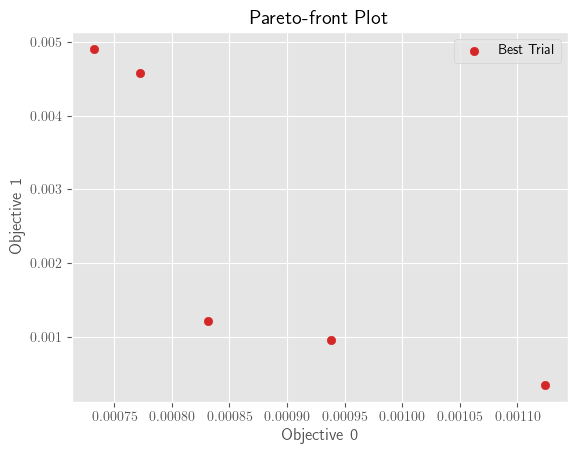

In [57]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
#plt.scatter(*attribs_focus.values(), color='green')

In [58]:
joblib.dump(opt_trial.study.trials, 
            save_dir /"trials.joblib", compress=4)

['/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/jupyter/sims_for_paper/beamline34/nf_fwhm_pl_pi_100/trials.joblib']

#### This is the analysis part

In [59]:
hist_dir = Path(save_dir)
hist_dir.exists()

True

In [60]:
trials_file = save_dir / "trials.joblib"

In [61]:
study = analysis.create_study_from_trials(trials_file, n_objectives=2)
n_steps = len(study.trials)

[I 2023-07-04 23:25:14,321] A new study created in memory with name: no-name-42354e73-6620-4221-869a-32ff2800459d


Assuming minimization for all objectives.


In [62]:
hists = analysis.load_histograms_from_files(n_steps, hist_dir, extension='gz')

In [63]:
nash_trial, nash_idx, n_doms = analysis.select_nash_equil_trial_from_pareto_front(study)

Trial number 26
Trial values: peak_distance 4.576e-03 fwhm 7.720e-04
Trial dw:
{'h_sigma': 0.007494262226299172, 'h_fwhm': 0.0006347656250000541, 'h_centroid': -0.005450383780477139, 'h_peak': 0.004565429687499999, 'v_sigma': 0.0008073720055359563, 'v_fwhm': 0.00043945312500003747, 'v_centroid': 5.6115795650038395e-05, 'v_peak': -0.00031738281250000104, 'integral_intensity': 8330.028552033495, 'peak_intensity': 7.93901424017775, 'gaussian_fit': {}}
Actual fwhm 0.0007720404443771116


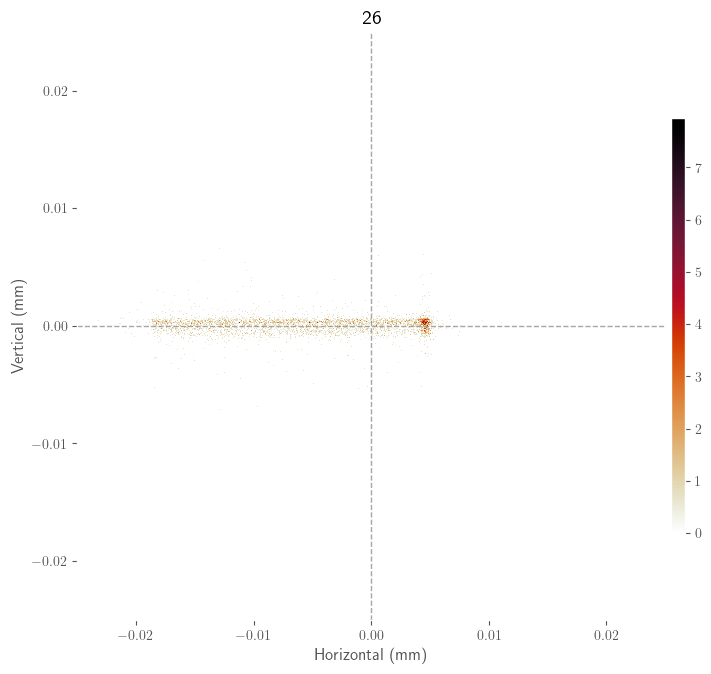

Trial number 49
Trial values: peak_distance 9.550e-04 fwhm 9.380e-04
Trial dw:
{'h_sigma': 0.0013134886210700756, 'h_fwhm': 0.0007324218750000625, 'h_centroid': 0.0005389256195024721, 'h_peak': 0.0005126953125000003, 'v_sigma': 0.000818530020784341, 'v_fwhm': 0.00058593750000005, 'v_centroid': -0.0010975840502333919, 'v_peak': 0.000805664062500001, 'integral_intensity': 8334.264452265395, 'peak_intensity': 23.36932520000312, 'gaussian_fit': {}}
Actual fwhm 0.0009379576519677824


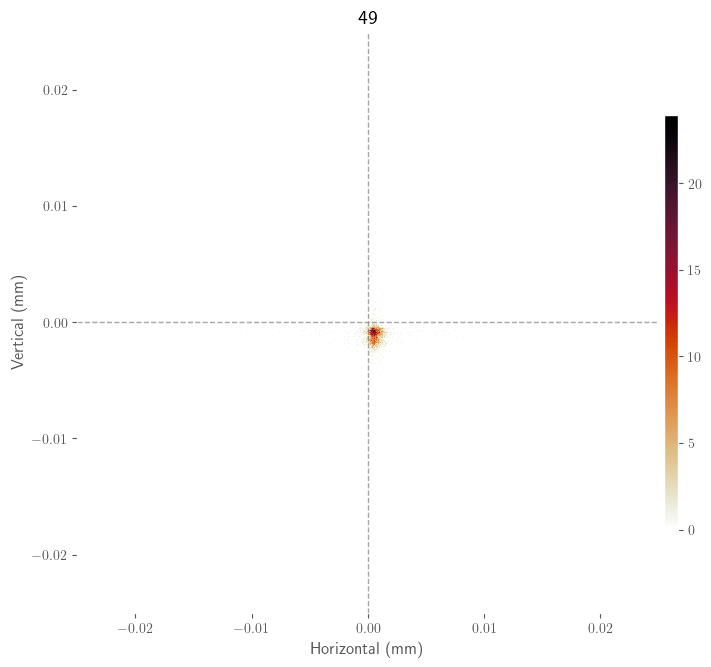

Trial number 89
Trial values: peak_distance 4.906e-03 fwhm 7.324e-04
Trial dw:
{'h_sigma': 0.0009149960848621642, 'h_fwhm': 0.00058593750000005, 'h_centroid': -0.0033083502102276537, 'h_peak': -0.003344726562499999, 'v_sigma': 0.0007257815404395214, 'v_fwhm': 0.00043945312500003747, 'v_centroid': 0.0035840164431663333, 'v_peak': -0.003588867187499999, 'integral_intensity': 8337.811154831581, 'peak_intensity': 47.56204428560989, 'gaussian_fit': {}}
Actual fwhm 0.0007324218750000625


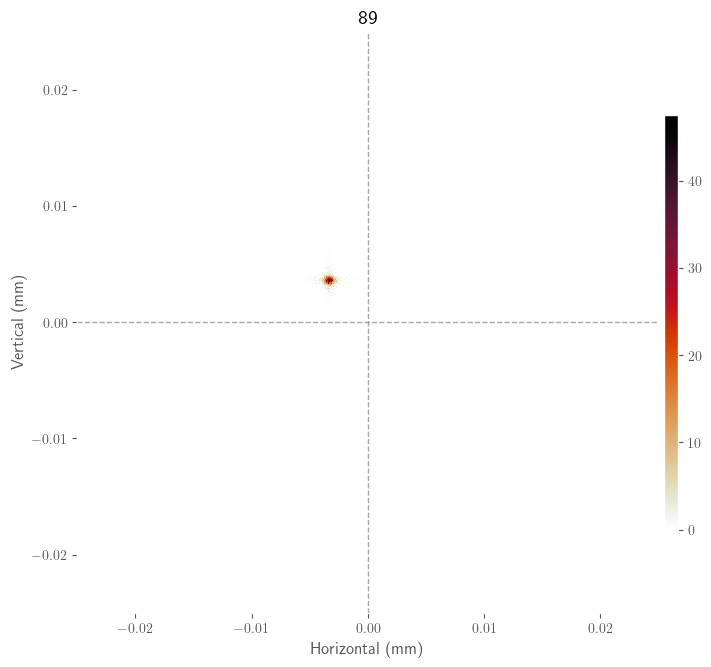

Trial number 115
Trial values: peak_distance 3.470e-04 fwhm 1.124e-03
Trial dw:
{'h_sigma': 0.0009729514136207295, 'h_fwhm': 0.0009277343750000791, 'h_centroid': -0.0006794362976137437, 'h_peak': -0.00026855468750000035, 'v_sigma': 0.0011309651795926004, 'v_fwhm': 0.0006347656250000541, 'v_centroid': -0.00010365019902714651, 'v_peak': 0.00021972656249999965, 'integral_intensity': 8339.85383031537, 'peak_intensity': 22.95093950317452, 'gaussian_fit': {}}
Actual fwhm 0.0011241078548068673


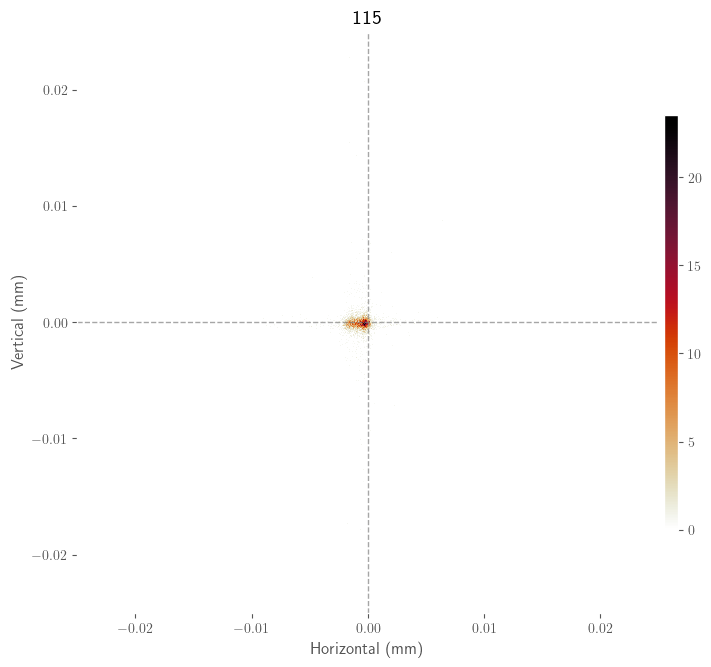

Trial number 123
Trial values: peak_distance 1.216e-03 fwhm 8.315e-04
Trial dw:
{'h_sigma': 0.0015490500024327861, 'h_fwhm': 0.0005371093750000458, 'h_centroid': 0.001140467792341251, 'h_peak': 0.0011962890624999997, 'v_sigma': 0.0007582278805289513, 'v_fwhm': 0.0006347656250000541, 'v_centroid': 0.00017351513070846424, 'v_peak': -0.00021972656249999965, 'integral_intensity': 8333.340744913914, 'peak_intensity': 34.003070935023075, 'gaussian_fit': {}}
Actual fwhm 0.0008315130061488209


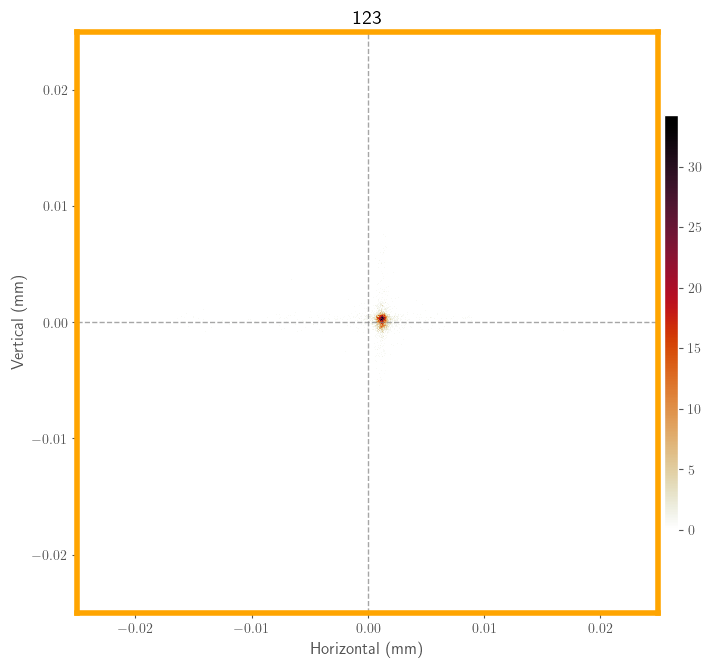

In [64]:
best_hists = []
for t in study.best_trials:
    print("Trial number", t.number)
    print(f"Trial values: peak_distance {t.values[1]:4.3e} fwhm {t.values[0]:4.3e}")
    print("Trial dw:")
    
    dw = dict(t.user_attrs["dw"]._DictionaryWrapper__dictionary)
    print(dw)
    print("Actual fwhm", opt_common._get_fwhm_from_dw(t.user_attrs["dw"]))
    hist = hists[t.number]
    plt.figure(figsize=[7,7], constrained_layout=True)
    plt.pcolormesh(hist.hh, hist.vv, hist.data_2D.T, cmap=m2)#, norm=mpl.colors.LogNorm(1, 4e2))
    #plt.xlim(-0.04,0.04)
    #plt.ylim(-0.04,0.04)
    plt.axhline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
    plt.axvline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
    plt.xlabel('Horizontal (mm)')
    plt.ylabel('Vertical (mm)')
    plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

    ax = plt.gca()
    ax.set_aspect('equal')
    if t.number == nash_trial.number:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(4)
            ax.spines[axis].set_color('orange')

    plt.title(t.number)
    plt.show()

### One step optimization

In [65]:

save_dir = cur_dir / f'nf_fwhm_pl_one_step_{DEFAULT_RANDOM_SEED}'
save_dir.mkdir(exist_ok=True)

In [66]:
movers.move_motors(focusing_system, list(initial_absolute_positions.keys()), perturbed_positions, movement='absolute')

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


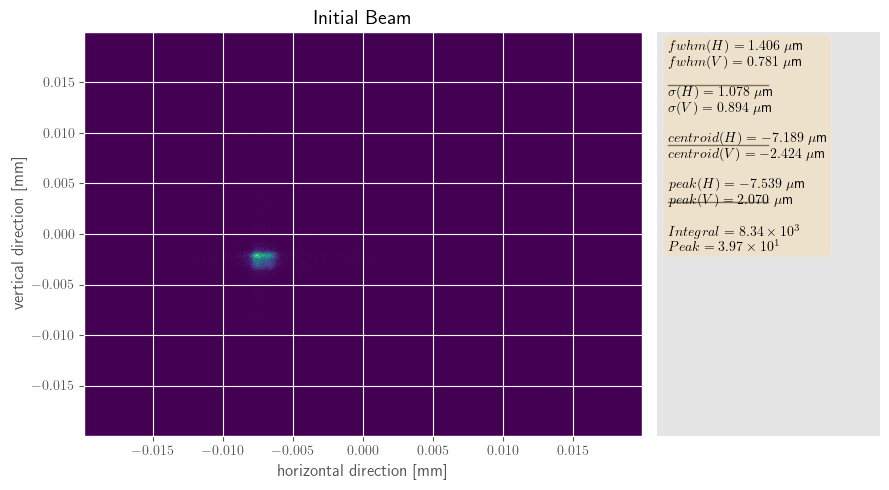

In [67]:
beam_pert, hist_pert, dw_pert = opt_common.get_beam_hist_dw(cp=cp, focusing_system=focusing_system, photon_beam=None)
opt_common.plot_distribution(
    photon_beam=beam_pert,
    title="Initial Beam",
    ppm=ppm
)

In [68]:
hist_pert.data_2D.max()

18.63015108069404

In [69]:
attribs_init = print_beam_attributes(opt_params.params["loss_parameters"], hist_pert, dw_pert, "Perturbed beam")

Perturbed beam system fwhm: 1.529e-03
Perturbed beam system peak_distance: 7.355e-03


In [70]:
opt_params = OptimizationParameters()

In [71]:
# Now the optimization
opt_trial = OptunaOptimizer(calculation_parameters=cp,
    focusing_system=focusing_system,
    motor_types=list(opt_params.move_motors_ranges.keys()),
    loss_parameters=opt_params.params["loss_parameters"],
    multi_objective_optimization=opt_params.params["multi_objective_optimization"],
    dump_directory=save_dir
    )

In [72]:
moo_thresholds = opt_params.params["moo_thresholds"]
for ltype in opt_params.params["loss_parameters"]:
    if ltype not in moo_thresholds:
        moo_thresholds[ltype] = opt_trial.get_beam_property_function_for_loss(ltype)()

In [73]:
attribs_init

{'fwhm': 0.0015285620939941272, 'peak_distance': 0.007354510925131322}

In [74]:
# Setting up the optimizer
constraints = {"sum_intensity": opt_params.params["sum_intensity_soft_constraint"]}#, "peak_distance": attribs_init["peak_distance"]}

opt_trial.set_optimizer_options(
    motor_ranges=list(opt_params.move_motors_ranges.values()),
    raise_prune_exception=True,
    use_discrete_space=True,
    sum_intensity_threshold=opt_params.params["sum_intensity_hard_constraint"],
    constraints=constraints,
    moo_thresholds=moo_thresholds
)

[I 2023-07-04 23:25:40,239] A new study created in memory with name: no-name-0b917ca4-edd0-4be8-adb9-aa17ee845946


In [75]:
opt_trial.trials(125)

/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:653: UserWarning: Fixed parameter 'hb_pitch' with value 0.0 is out of range for distribution FloatDistribution(high=0.0185, log=False, low=-0.02, step=0.00175).
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/trial/_trial.py:653: UserWarning: Fixed parameter 'vb_pitch' with value 0.0 is out of range for distribution FloatDistribution(high=0.0185, log=False, low=-0.02, step=0.00175).
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:25:53,311] Trial 1 finished with values: [0.003690967029094896, 0.011510861533473412] and parameters: {'hb_trans': 1.7000000000000028, 'vb_trans': -8.899999999999999, 'hb_pitch': -0.00425, 'vb_pitch': 0.013250000000000001, 'hb_1': -29.7169, 'hb_2': -22.7059, 'vb_1': 10.244900000000001, 'vb_2': 19.551100000000005}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:26:01,778] Trial 2 finished with values: [0.0017318503760712608, 0.011816860221780514] and parameters: {'hb_trans': -14.6, 'vb_trans': 3.0, 'hb_pitch': 0.015000000000000003, 'vb_pitch': -0.013000000000000001, 'hb_1': -18.8804, 'hb_2': -23.4974, 'vb_1': -16.818199999999997, 'vb_2': 28.717400000000005}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:26:09,308] Trial 3 pruned. 


Pruning trial with parameters [12.399999999999999, -13.2, 0.0115, -0.0095, -4.097799999999999, 26.401700000000005, 19.0589, -9.833299999999998]
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:26:18,604] Trial 4 finished with values: [0.001964080601671922, 0.011755364755725837] and parameters: {'hb_trans': -13.0, 'vb_trans': -5.1, 'hb_pitch': -0.02, 'vb_pitch': -0.01125, 'hb_1': 17.7397, 'hb_2': -29.0848, 'vb_1': 5.930599999999998, 'vb_2': 6.228200000000001}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:26:27,140] Trial 5 pruned. 


Pruning trial with parameters [-15.8, -4.799999999999999, -0.02, 0.015000000000000003, 28.855200000000004, -26.4035, 23.432700000000004, 4.614000000000004]
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:26:35,460] Trial 6 finished with values: [0.0011357132177357422, 0.017622996385466716] and parameters: {'hb_trans': 9.600000000000001, 'vb_trans': 5.200000000000003, 'hb_pitch': 0.002749999999999999, 'vb_pitch': -0.02, 'hb_1': -17.3985, 'hb_2': 2.6810000000000045, 'vb_1': 16.146900000000002, 'vb_2': -14.9583}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:26:42,589] Trial 7 finished with values: [0.0011241078548068673, 0.019706882442218774] and parameters: {'hb_trans': -8.6, 'vb_trans': 14.0, 'hb_pitch': 0.0185, 'vb_pitch': 0.015000000000000003, 'hb_1': -8.4296, 'hb_2': 5.9315, 'vb_1': -8.712299999999999, 'vb_2': -9.5886}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:26:50,544] Trial 8 finished with values: [0.0017753573205761125, 0.013029380536171784] and parameters: {'hb_trans': -12.899999999999999, 'vb_trans': -10.5, 'hb_pitch': -0.01825, 'vb_pitch': -0.0007500000000000007, 'hb_1': -7.424899999999997, 'hb_2': 5.568300000000001, 'vb_1': 7.796500000000002, 'vb_2': -21.444}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:26:57,460] Trial 9 pruned. 


Pruning trial with parameters [17.300000000000004, 17.800000000000004, 0.002749999999999999, -0.006, -8.2088, -17.7393, -13.394099999999998, -15.207899999999999]
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:27:04,504] Trial 10 pruned. 


Pruning trial with parameters [-13.1, 18.6, 0.0185, 0.002749999999999999, 13.878, -9.576899999999998, -24.4767, -2.1901999999999973]
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:27:11,421] Trial 11 pruned. 


Pruning trial with parameters [0.3000000000000007, -16.5, 0.0010000000000000009, 0.0185, -6.2978999999999985, -9.8643, 18.327000000000005, 15.2609]
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:27:18,715] Trial 12 finished with values: [0.0019445613038810133, 0.0007941140609028625] and parameters: {'hb_trans': -7.5, 'vb_trans': 5.300000000000001, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': -0.0095, 'hb_1': -23.3528, 'hb_2': -11.241599999999998, 'vb_1': -2.581299999999999, 'vb_2': 9.5364}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:27:26,562] Trial 13 finished with values: [0.0023624942194148393, 0.006483393215631841] and parameters: {'hb_trans': -9.899999999999999, 'vb_trans': 5.600000000000001, 'hb_pitch': -0.013000000000000001, 'vb_pitch': 0.006249999999999999, 'hb_1': 16.697300000000006, 'hb_2': 16.7759, 'vb_1': 6.619599999999998, 'vb_2': -11.46}. 


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:27:33,899] Trial 14 finished with values: [0.005437708357403956, 0.024518939774571567] and parameters: {'hb_trans': 7.900000000000002, 'vb_trans': 14.300000000000004, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': 0.0185, 'hb_1': 28.590000000000003, 'hb_2': -19.9984, 'vb_1': -28.6094, 'vb_2': -20.3554}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:27:42,412] Trial 15 finished with values: [0.0012010130738525284, 0.01053517010001523] and parameters: {'hb_trans': -12.7, 'vb_trans': -3.8000000000000007, 'hb_pitch': 0.006249999999999999, 'vb_pitch': -0.006, 'hb_1': -22.208199999999998, 'hb_2': 1.4415000000000013, 'vb_1': -6.839700000000001, 'vb_2': 6.2120999999999995}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:27:51,745] Trial 16 pruned. 


Pruning trial with parameters [-7.799999999999999, 11.200000000000003, 0.0010000000000000009, -0.0165, -9.4114, -4.9670999999999985, 5.805300000000003, 1.9029000000000025]


/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-30, 29.999900000000004] and step=0.0001, but the range is not divisible by `step`. It will be replaced by [-30, 29.9999].
  warnings.warn(


write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:28:00,760] Trial 17 finished with values: [0.0013982247132107006, 0.00957361281184476] and parameters: {'hb_trans': -16.5, 'vb_trans': 5.200000000000003, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': -0.013000000000000001, 'hb_1': -18.6695, 'hb_2': -7.549599999999998, 'vb_1': -6.125499999999999, 'vb_2': 20.474400000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:28:09,651] Trial 18 finished with values: [0.0009328600182883022, 0.004991108618075423] and parameters: {'hb_trans': -7.0, 'vb_trans': 0.3000000000000007, 'hb_pitch': -0.006, 'vb_pitch': -0.006, 'hb_1': -16.981499999999997, 'hb_2': 10.725500000000004, 'vb_1': -6.818299999999997, 'vb_2': -6.041499999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:28:19,319] Trial 19 finished with values: [0.001532456526023101, 0.01249394270045571] and parameters: {'hb_trans': 2.700000000000003, 'vb_trans': 1.3000000000000007, 'hb_pitch': -0.00425, 'vb_pitch': -0.013000000000000001, 'hb_1': -3.7358999999999973, 'hb_2': 6.213500000000003, 'vb_1': -5.5783999999999985, 'vb_2': -0.39399999999999835}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Con

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:28:27,491] Trial 20 finished with values: [0.024132210953399336, 0.006188374929510047] and parameters: {'hb_trans': -8.299999999999999, 'vb_trans': 9.900000000000002, 'hb_pitch': 0.002749999999999999, 'vb_pitch': -0.00425, 'hb_1': -6.052299999999999, 'hb_2': 1.4185000000000016, 'vb_1': 2.189700000000002, 'vb_2': -3.5860999999999983}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Conten

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:28:35,340] Trial 21 finished with values: [0.001840632502438708, 0.006162120982308799] and parameters: {'hb_trans': -3.0, 'vb_trans': 0.20000000000000284, 'hb_pitch': -0.00425, 'vb_pitch': -0.0007500000000000007, 'hb_1': -21.9196, 'hb_2': 17.205200000000005, 'vb_1': -3.132299999999997, 'vb_2': 12.036300000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:28:43,901] Trial 22 finished with values: [0.0014260822135265115, 0.00046961386869314787] and parameters: {'hb_trans': -7.299999999999999, 'vb_trans': 2.8000000000000007, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': -0.0007500000000000007, 'hb_1': -20.2444, 'hb_2': -14.728399999999999, 'vb_1': -7.770999999999997, 'vb_2': 10.7778}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Content

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:28:54,713] Trial 23 finished with values: [0.0021672208028490274, 0.00502443541586206] and parameters: {'hb_trans': -6.299999999999999, 'vb_trans': 3.6000000000000014, 'hb_pitch': -0.01125, 'vb_pitch': -0.01125, 'hb_1': -19.5886, 'hb_2': -3.0405999999999977, 'vb_1': 2.8104000000000013, 'vb_2': 8.918199999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:29:05,055] Trial 24 finished with values: [0.0015540850061368072, 0.010843417291731517] and parameters: {'hb_trans': -5.799999999999999, 'vb_trans': -4.1, 'hb_pitch': -0.006, 'vb_pitch': -0.0095, 'hb_1': -22.4274, 'hb_2': -17.2964, 'vb_1': -9.049299999999999, 'vb_2': 9.913499999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:29:14,339] Trial 25 finished with values: [0.003257242203156121, 0.003286571728442312] and parameters: {'hb_trans': -7.1, 'vb_trans': 1.1000000000000014, 'hb_pitch': 0.009750000000000002, 'vb_pitch': -0.0024999999999999988, 'hb_1': -29.026, 'hb_2': -3.9660999999999973, 'vb_1': 4.883299999999998, 'vb_2': 21.944200000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:29:23,818] Trial 26 finished with values: [0.0009328600182883022, 0.001494252319150328] and parameters: {'hb_trans': -6.199999999999999, 'vb_trans': 3.900000000000002, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': -0.00775, 'hb_1': -17.3002, 'hb_2': -27.3564, 'vb_1': 12.761500000000005, 'vb_2': 0.7301000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pyth

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:29:33,404] Trial 27 finished with values: [0.0038462803893182925, 0.002020623212554548] and parameters: {'hb_trans': -6.5, 'vb_trans': 3.0, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': -0.00775, 'hb_1': -11.906099999999999, 'hb_2': -10.879099999999998, 'vb_1': 12.941900000000004, 'vb_2': 21.818600000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fr

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:29:42,353] Trial 28 finished with values: [0.00306724585440249, 0.004866305104415741] and parameters: {'hb_trans': -1.6999999999999993, 'vb_trans': 2.900000000000002, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': 0.002749999999999999, 'hb_1': -19.1707, 'hb_2': -12.275499999999997, 'vb_1': 1.9378000000000029, 'vb_2': 28.762300000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Co

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:29:53,875] Trial 29 finished with values: [0.0022064694390031185, 0.003985553641922487] and parameters: {'hb_trans': -7.199999999999999, 'vb_trans': 3.400000000000002, 'hb_pitch': -0.013000000000000001, 'vb_pitch': -0.00775, 'hb_1': -18.3778, 'hb_2': -29.9362, 'vb_1': 0.6158000000000001, 'vb_2': 10.4833}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framewor

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:30:04,806] Trial 30 finished with values: [0.0013147375017419343, 0.005593857918662625] and parameters: {'hb_trans': -4.199999999999999, 'vb_trans': 2.900000000000002, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': -0.01125, 'hb_1': -10.7408, 'hb_2': -21.8618, 'vb_1': -0.8542999999999985, 'vb_2': -12.9341}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:30:15,712] Trial 31 finished with values: [0.0015285620939941272, 0.007119284629673522] and parameters: {'hb_trans': -10.2, 'vb_trans': 1.5, 'hb_pitch': 0.009750000000000002, 'vb_pitch': -0.0095, 'hb_1': -17.328899999999997, 'hb_2': -23.9099, 'vb_1': -4.2349, 'vb_2': -3.6891999999999996}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/li

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:30:26,054] Trial 32 finished with values: [0.0016815600935277376, 0.006304030524794747] and parameters: {'hb_trans': -4.1, 'vb_trans': 3.5, 'hb_pitch': -0.00775, 'vb_pitch': 0.0045000000000000005, 'hb_1': -3.8538999999999994, 'hb_2': -10.261499999999998, 'vb_1': 0.2430000000000021, 'vb_2': 5.095700000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:30:35,836] Trial 33 finished with values: [0.0014084184669782408, 0.004627736905637338] and parameters: {'hb_trans': -3.1999999999999993, 'vb_trans': 3.5, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': -0.0007500000000000007, 'hb_1': -18.779899999999998, 'hb_2': -25.0036, 'vb_1': 0.4919000000000011, 'vb_2': -19.7109}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/P

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:30:46,576] Trial 34 finished with values: [0.0010381001770249567, 0.0024190874362138817] and parameters: {'hb_trans': -9.299999999999999, 'vb_trans': 4.100000000000001, 'hb_pitch': -0.013000000000000001, 'vb_pitch': -0.0007500000000000007, 'hb_1': -25.399, 'hb_2': 9.635600000000004, 'vb_1': 14.277500000000003, 'vb_2': -7.846899999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/C

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:30:56,396] Trial 35 finished with values: [0.0016815600935277376, 0.0026666147306470987] and parameters: {'hb_trans': -11.799999999999999, 'vb_trans': 3.0, 'hb_pitch': -0.00775, 'vb_pitch': -0.0007500000000000007, 'hb_1': 7.822200000000002, 'hb_2': 2.1888000000000005, 'vb_1': 26.235600000000005, 'vb_2': -22.1254}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:31:07,065] Trial 36 finished with values: [0.0008400708268597032, 0.0035549088293904702] and parameters: {'hb_trans': -5.399999999999999, 'vb_trans': 4.900000000000002, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': -0.0024999999999999988, 'hb_1': -24.3378, 'hb_2': 10.976600000000005, 'vb_1': -12.612299999999998, 'vb_2': 1.101700000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:31:17,509] Trial 37 finished with values: [0.0012128654637085234, 0.001621284933191797] and parameters: {'hb_trans': -11.4, 'vb_trans': 2.8000000000000007, 'hb_pitch': -0.01475, 'vb_pitch': 0.0010000000000000009, 'hb_1': -24.6324, 'hb_2': -11.1954, 'vb_1': 14.839500000000001, 'vb_2': 4.549100000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:31:28,875] Trial 38 finished with values: [0.0020744771275634584, 0.004922809814808847] and parameters: {'hb_trans': -11.1, 'vb_trans': 1.2000000000000028, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': -0.0024999999999999988, 'hb_1': -21.9414, 'hb_2': -13.0686, 'vb_1': 11.382800000000003, 'vb_2': -27.5678}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:31:38,782] Trial 39 finished with values: [0.0019683246455808683, 0.0014668768443163857] and parameters: {'hb_trans': -8.899999999999999, 'vb_trans': 1.5, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': -0.0007500000000000007, 'hb_1': -24.1555, 'hb_2': -21.8442, 'vb_1': -3.2544000000000004, 'vb_2': 5.925600000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Py

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:31:48,809] Trial 40 finished with values: [0.001806640625000154, 0.0026096794270630505] and parameters: {'hb_trans': -9.899999999999999, 'vb_trans': 3.1000000000000014, 'hb_pitch': -0.00425, 'vb_pitch': 0.002749999999999999, 'hb_1': -25.3228, 'hb_2': -24.9878, 'vb_1': -12.940099999999997, 'vb_2': -8.709399999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pyt

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:31:58,917] Trial 41 finished with values: [0.0016377451007079935, 0.002866547806811418] and parameters: {'hb_trans': -10.5, 'vb_trans': 4.0, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': -0.0007500000000000007, 'hb_1': -5.9939, 'hb_2': 13.163900000000005, 'vb_1': 24.4343, 'vb_2': -10.0073}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:32:11,016] Trial 42 finished with values: [0.0020536856293764537, 0.0021027297851693837] and parameters: {'hb_trans': -10.799999999999999, 'vb_trans': 3.8000000000000007, 'hb_pitch': -0.006, 'vb_pitch': -0.00425, 'hb_1': -11.210999999999999, 'hb_2': -11.981099999999998, 'vb_1': 19.959000000000003, 'vb_2': -28.7877}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pyth

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:32:24,067] Trial 43 finished with values: [0.0010066175843793975, 0.0027537071210143598] and parameters: {'hb_trans': -10.399999999999999, 'vb_trans': 4.200000000000003, 'hb_pitch': -0.0165, 'vb_pitch': 0.0010000000000000009, 'hb_1': -5.268599999999999, 'hb_2': -16.0108, 'vb_1': 16.069000000000003, 'vb_2': -7.005099999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:32:35,972] Trial 44 finished with values: [0.0015942214567691308, 0.0036612954824741142] and parameters: {'hb_trans': -10.0, 'vb_trans': 4.200000000000003, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': -0.0007500000000000007, 'hb_1': -2.774799999999999, 'hb_2': -25.3463, 'vb_1': -6.905099999999997, 'vb_2': 12.966300000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:32:49,539] Trial 45 finished with values: [0.0014501213286053482, 0.001283074545260831] and parameters: {'hb_trans': -12.6, 'vb_trans': 0.6000000000000014, 'hb_pitch': -0.02, 'vb_pitch': 0.006249999999999999, 'hb_1': -12.769299999999998, 'hb_2': 8.345400000000005, 'vb_1': 18.2855, 'vb_2': -14.879399999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:33:02,549] Trial 46 finished with values: [0.0015073583047299265, 0.0009296598029619029] and parameters: {'hb_trans': -9.899999999999999, 'vb_trans': 1.7000000000000028, 'hb_pitch': -0.01475, 'vb_pitch': 0.002749999999999999, 'hb_1': -10.698699999999999, 'hb_2': -12.0028, 'vb_1': 4.258400000000002, 'vb_2': -21.0795}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pyt

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:33:14,918] Trial 47 finished with values: [0.0012477472987482154, 0.005872076890041843] and parameters: {'hb_trans': -15.2, 'vb_trans': 4.0, 'hb_pitch': -0.01825, 'vb_pitch': 0.006249999999999999, 'hb_1': -6.178699999999999, 'hb_2': 7.5427000000000035, 'vb_1': 21.038600000000002, 'vb_2': -8.240399999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:33:26,937] Trial 48 finished with values: [0.0025353037081539604, 0.003334106514586831] and parameters: {'hb_trans': -9.2, 'vb_trans': -1.3000000000000007, 'hb_pitch': -0.01475, 'vb_pitch': 0.0010000000000000009, 'hb_1': 9.265, 'hb_2': 18.0332, 'vb_1': 18.5963, 'vb_2': -9.120899999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/l

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:33:39,230] Trial 49 finished with values: [0.0018759153039355648, 0.001989708648516523] and parameters: {'hb_trans': -12.899999999999999, 'vb_trans': -3.099999999999998, 'hb_pitch': -0.01475, 'vb_pitch': 0.0115, 'hb_1': -15.8142, 'hb_2': 13.107100000000003, 'vb_1': 20.9551, 'vb_2': -20.407899999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:33:51,534] Trial 50 finished with values: [0.0008963652222015324, 0.004155414009630168] and parameters: {'hb_trans': -10.0, 'vb_trans': 1.4000000000000021, 'hb_pitch': -0.01475, 'vb_pitch': 0.009750000000000002, 'hb_1': -23.2499, 'hb_2': 27.817100000000003, 'vb_1': 5.0047, 'vb_2': -2.5889999999999986}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/V

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:34:03,234] Trial 51 finished with values: [0.0010449675077653575, 0.004749774525962822] and parameters: {'hb_trans': -8.2, 'vb_trans': -2.8000000000000007, 'hb_pitch': -0.02, 'vb_pitch': 0.006249999999999999, 'hb_1': -27.2957, 'hb_2': -2.9812999999999974, 'vb_1': -5.1281, 'vb_2': -13.182499999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ve

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:34:14,278] Trial 52 finished with values: [0.0009480706952611941, 0.002153148687534115] and parameters: {'hb_trans': -8.5, 'vb_trans': -5.399999999999999, 'hb_pitch': -0.00775, 'vb_pitch': 0.0115, 'hb_1': -19.8413, 'hb_2': 12.359900000000003, 'vb_1': 23.285800000000002, 'vb_2': 1.3916000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:34:28,426] Trial 53 finished with values: [0.0009630411583651221, 0.00247559075289226] and parameters: {'hb_trans': -10.299999999999999, 'vb_trans': -1.5, 'hb_pitch': -0.00775, 'vb_pitch': 0.002749999999999999, 'hb_1': 3.162399999999998, 'hb_2': -16.662300000000002, 'vb_1': 25.491800000000005, 'vb_2': -0.5936999999999983}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framewor

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:34:43,584] Trial 54 finished with values: [0.000656915236673577, 0.003005409767280113] and parameters: {'hb_trans': -13.3, 'vb_trans': -0.8999999999999986, 'hb_pitch': -0.01125, 'vb_pitch': 0.006249999999999999, 'hb_1': -19.951, 'hb_2': -0.6485999999999983, 'vb_1': 22.087500000000006, 'vb_2': -3.647199999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:34:58,617] Trial 55 finished with values: [0.0013282686043688088, 0.004998745760962369] and parameters: {'hb_trans': -8.7, 'vb_trans': -5.1, 'hb_pitch': -0.0165, 'vb_pitch': 0.008, 'hb_1': -23.508499999999998, 'hb_2': 10.970500000000001, 'vb_1': 29.393800000000006, 'vb_2': -13.8615}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/pyt

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:35:13,419] Trial 56 finished with values: [0.0011799849583589454, 0.0020787825153718753] and parameters: {'hb_trans': -10.1, 'vb_trans': -1.8000000000000007, 'hb_pitch': -0.02, 'vb_pitch': 0.008, 'hb_1': -12.337499999999999, 'hb_2': -23.9653, 'vb_1': 11.929400000000001, 'vb_2': -5.806699999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:35:27,588] Trial 57 finished with values: [0.0019683246455808683, 0.005327526607080017] and parameters: {'hb_trans': -11.1, 'vb_trans': -1.0, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': 0.016749999999999998, 'hb_1': -13.1491, 'hb_2': -14.3036, 'vb_1': 18.8562, 'vb_2': -23.2019}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/pyth

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:35:43,507] Trial 58 finished with values: [0.0012601062402895547, 0.0025204489759090816] and parameters: {'hb_trans': -6.799999999999999, 'vb_trans': 2.900000000000002, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': -0.00775, 'hb_1': -29.0555, 'hb_2': -10.285499999999999, 'vb_1': 16.375800000000005, 'vb_2': 2.030700000000003}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:35:57,192] Trial 59 finished with values: [0.000969210607484419, 0.0019436415270991348] and parameters: {'hb_trans': -8.299999999999999, 'vb_trans': -5.799999999999999, 'hb_pitch': -0.00775, 'vb_pitch': 0.013250000000000001, 'hb_1': 18.6053, 'hb_2': 0.9624000000000024, 'vb_1': 19.313900000000004, 'vb_2': -8.775499999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:36:10,868] Trial 60 finished with values: [0.0010300304252798234, 0.0025090720557960785] and parameters: {'hb_trans': -5.1, 'vb_trans': -2.8000000000000007, 'hb_pitch': 0.006249999999999999, 'vb_pitch': 0.0045000000000000005, 'hb_1': 4.252299999999998, 'hb_2': -12.2561, 'vb_1': 20.189700000000002, 'vb_2': 0.7421000000000006}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:36:28,460] Trial 61 finished with values: [0.002441406250000208, 0.004066682276669753] and parameters: {'hb_trans': -7.5, 'vb_trans': -3.8000000000000007, 'hb_pitch': -0.01475, 'vb_pitch': 0.013250000000000001, 'hb_1': 6.884399999999999, 'hb_2': 7.145400000000002, 'vb_1': 28.344100000000005, 'vb_2': 17.0606}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:36:44,601] Trial 62 finished with values: [0.001441877251976041, 0.004690677837198765] and parameters: {'hb_trans': -10.0, 'vb_trans': -4.799999999999999, 'hb_pitch': 0.006249999999999999, 'vb_pitch': 0.0115, 'hb_1': 14.6768, 'hb_2': 3.986699999999999, 'vb_1': 12.7061, 'vb_2': -15.308}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:36:58,853] Trial 63 finished with values: [0.00125061020262371, 0.001606512097300987] and parameters: {'hb_trans': -9.2, 'vb_trans': -1.6999999999999993, 'hb_pitch': -0.00425, 'vb_pitch': 0.0045000000000000005, 'hb_1': -1.1876999999999995, 'hb_2': -25.0093, 'vb_1': -10.2104, 'vb_2': 5.1295}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:37:13,091] Trial 64 finished with values: [0.0018380400610078435, 0.003943456836571109] and parameters: {'hb_trans': -7.899999999999999, 'vb_trans': -3.3999999999999986, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': 0.002749999999999999, 'hb_1': 10.563300000000005, 'hb_2': 8.7194, 'vb_1': 11.1402, 'vb_2': -4.369199999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Fra

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:37:28,490] Trial 65 finished with values: [0.0023340660942808866, 0.0035042472681912702] and parameters: {'hb_trans': -10.2, 'vb_trans': -2.8000000000000007, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': 0.015000000000000003, 'hb_1': -22.9262, 'hb_2': -7.2791999999999994, 'vb_1': 2.8935999999999993, 'vb_2': 12.859200000000001}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/F

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:37:43,278] Trial 66 finished with values: [0.0009630411583651221, 0.0003183204299415353] and parameters: {'hb_trans': -8.2, 'vb_trans': -1.5, 'hb_pitch': -0.00425, 'vb_pitch': 0.008, 'hb_1': -10.407599999999999, 'hb_2': -23.167, 'vb_1': -11.6604, 'vb_2': -16.597}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:37:57,080] Trial 67 finished with values: [0.0010483843043743027, 0.0019436415270991348] and parameters: {'hb_trans': -8.899999999999999, 'vb_trans': -3.599999999999998, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': 0.009750000000000002, 'hb_1': -5.451799999999999, 'hb_2': -22.625999999999998, 'vb_1': 17.369500000000002, 'vb_2': -5.5853}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:38:12,408] Trial 68 finished with values: [0.001441877251976041, 0.00498250283983363] and parameters: {'hb_trans': -4.199999999999999, 'vb_trans': -4.899999999999999, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': 0.006249999999999999, 'hb_1': -7.771100000000001, 'hb_2': -22.1387, 'vb_1': 11.239200000000004, 'vb_2': -15.434}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frame

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:38:25,524] Trial 69 finished with values: [0.0016061410354882744, 0.002838968134116394] and parameters: {'hb_trans': -6.0, 'vb_trans': -6.899999999999999, 'hb_pitch': -0.00425, 'vb_pitch': 0.015000000000000003, 'hb_1': -16.6597, 'hb_2': -8.476399999999998, 'vb_1': -4.1371, 'vb_2': 9.8596}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/l

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:38:40,308] Trial 70 finished with values: [0.0021617132442559124, 0.0031305264244164636] and parameters: {'hb_trans': -9.7, 'vb_trans': -2.6999999999999993, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': 0.015000000000000003, 'hb_1': -1.3988999999999976, 'hb_2': -11.7238, 'vb_1': -24.3113, 'vb_2': -16.9242}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:38:54,927] Trial 71 finished with values: [0.0014058769578993355, 0.005006371253518036] and parameters: {'hb_trans': -7.0, 'vb_trans': -7.399999999999999, 'hb_pitch': -0.0095, 'vb_pitch': 0.0115, 'hb_1': -1.8134999999999977, 'hb_2': 8.846699999999998, 'vb_1': 7.0242, 'vb_2': -2.1184999999999974}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Version

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:39:10,617] Trial 72 finished with values: [0.0012900239075804719, 0.002710950516111583] and parameters: {'hb_trans': -8.5, 'vb_trans': -4.799999999999999, 'hb_pitch': -0.013000000000000001, 'vb_pitch': 0.0185, 'hb_1': -6.256599999999999, 'hb_2': -1.1707, 'vb_1': -0.8297999999999988, 'vb_2': -26.8024}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ve

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:39:26,652] Trial 73 finished with values: [0.004367320268554649, 0.002069586860597924] and parameters: {'hb_trans': -10.9, 'vb_trans': -6.699999999999999, 'hb_pitch': -0.00775, 'vb_pitch': 0.016749999999999998, 'hb_1': 4.978200000000001, 'hb_2': -12.1418, 'vb_1': 19.5122, 'vb_2': 25.143100000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ver

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:39:43,695] Trial 74 finished with values: [0.0017605230837228012, 0.002703905643351745] and parameters: {'hb_trans': -9.7, 'vb_trans': -6.199999999999999, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': 0.013250000000000001, 'hb_1': 7.903800000000004, 'hb_2': -7.440300000000001, 'vb_1': -20.5589, 'vb_2': -19.0763}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pytho

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:39:56,790] Trial 75 finished with values: [0.0008976941558033107, 0.003245693287666372] and parameters: {'hb_trans': -6.1, 'vb_trans': -1.0, 'hb_pitch': -0.00425, 'vb_pitch': 0.0115, 'hb_1': -12.916599999999999, 'hb_2': -14.0491, 'vb_1': -1.6379999999999981, 'vb_2': -3.9223}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/s

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:40:12,094] Trial 76 finished with values: [0.0009480706952611941, 0.002106128596307588] and parameters: {'hb_trans': -11.0, 'vb_trans': -3.099999999999998, 'hb_pitch': -0.02, 'vb_pitch': 0.008, 'hb_1': 12.765799999999999, 'hb_2': -6.0001, 'vb_1': 4.859999999999999, 'vb_2': -9.6827}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/pyth

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:40:30,076] Trial 77 finished with values: [0.002319721390668109, 0.001470123947004355] and parameters: {'hb_trans': -9.799999999999999, 'vb_trans': -5.1, 'hb_pitch': -0.01825, 'vb_pitch': 0.015000000000000003, 'hb_1': 20.8654, 'hb_2': -26.948999999999998, 'vb_1': 6.152500000000003, 'vb_2': -28.3039}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ver

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:40:45,552] Trial 78 finished with values: [0.0015254393898256485, 0.001900223508036138] and parameters: {'hb_trans': -10.399999999999999, 'vb_trans': 0.20000000000000284, 'hb_pitch': -0.02, 'vb_pitch': 0.002749999999999999, 'hb_1': -10.141299999999998, 'hb_2': -28.5998, 'vb_1': 3.5343000000000018, 'vb_2': -14.8196}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pyth

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:41:00,160] Trial 79 finished with values: [0.0010719969921924816, 0.0018901593604341719] and parameters: {'hb_trans': -9.899999999999999, 'vb_trans': -5.0, 'hb_pitch': -0.006, 'vb_pitch': 0.0115, 'hb_1': -12.2778, 'hb_2': -28.6711, 'vb_1': 16.6749, 'vb_2': -5.244599999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:41:15,621] Trial 80 finished with values: [0.0013601941676938776, 0.0015930994239331503] and parameters: {'hb_trans': -7.899999999999999, 'vb_trans': -1.1999999999999993, 'hb_pitch': -0.006, 'vb_pitch': 0.009750000000000002, 'hb_1': 7.388800000000003, 'hb_2': -28.5957, 'vb_1': -25.6146, 'vb_2': -0.4817999999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pyth

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:41:31,909] Trial 81 finished with values: [0.001488256899817331, 0.0027795600471632437] and parameters: {'hb_trans': -11.5, 'vb_trans': -4.199999999999999, 'hb_pitch': -0.00775, 'vb_pitch': 0.0185, 'hb_1': 15.929900000000004, 'hb_2': 8.789100000000005, 'vb_1': -2.9476999999999975, 'vb_2': -15.0152}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Vers

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:41:48,167] Trial 82 finished with values: [0.0011241078548068673, 0.002052233953483156] and parameters: {'hb_trans': -7.699999999999999, 'vb_trans': 5.300000000000001, 'hb_pitch': 0.002749999999999999, 'vb_pitch': -0.00425, 'hb_1': -28.7698, 'hb_2': -7.5701, 'vb_1': -17.0319, 'vb_2': 22.605000000000004}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:42:01,680] Trial 83 finished with values: [0.0019876105895556013, 0.002129768406988709] and parameters: {'hb_trans': -8.1, 'vb_trans': -6.1, 'hb_pitch': -0.0095, 'vb_pitch': 0.015000000000000003, 'hb_1': -27.6401, 'hb_2': -25.1279, 'vb_1': -5.2906999999999975, 'vb_2': 3.2306000000000026}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/li

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:42:18,443] Trial 84 finished with values: [0.0009480706952611941, 0.002078782515371876] and parameters: {'hb_trans': -8.899999999999999, 'vb_trans': -2.1999999999999993, 'hb_pitch': -0.0095, 'vb_pitch': 0.013250000000000001, 'hb_1': 26.240300000000005, 'hb_2': -14.9718, 'vb_1': 5.698700000000002, 'vb_2': -6.221}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:42:34,121] Trial 85 finished with values: [0.0008315130061488209, 0.00247559075289226] and parameters: {'hb_trans': -9.1, 'vb_trans': -1.0, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': 0.002749999999999999, 'hb_1': 3.984500000000004, 'hb_2': -0.3036999999999992, 'vb_1': -13.771899999999999, 'vb_2': -19.494999999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:42:51,103] Trial 86 finished with values: [0.0013336426058348464, 0.001581081529169159] and parameters: {'hb_trans': -7.799999999999999, 'vb_trans': -4.799999999999999, 'hb_pitch': -0.00775, 'vb_pitch': 0.015000000000000003, 'hb_1': -19.2118, 'hb_2': -0.23329999999999984, 'vb_1': 1.8616000000000028, 'vb_2': -18.1058}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Py

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:43:05,862] Trial 87 finished with values: [0.0012900239075804719, 0.0027424285000267187] and parameters: {'hb_trans': -6.899999999999999, 'vb_trans': -7.899999999999999, 'hb_pitch': -0.006, 'vb_pitch': 0.0185, 'hb_1': -24.857599999999998, 'hb_2': 0.2561, 'vb_1': 4.328400000000002, 'vb_2': -14.2282}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Vers

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:43:23,071] Trial 88 finished with values: [0.0016164985700437755, 0.0012793527838451072] and parameters: {'hb_trans': -12.899999999999999, 'vb_trans': 2.8000000000000007, 'hb_pitch': -0.01825, 'vb_pitch': -0.0024999999999999988, 'hb_1': -18.147100000000002, 'hb_2': 4.372, 'vb_1': 1.909200000000002, 'vb_2': -23.8582}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pyt

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:43:36,903] Trial 89 finished with values: [0.0015882281218058574, 0.0030674401745173717] and parameters: {'hb_trans': -6.799999999999999, 'vb_trans': -1.1999999999999993, 'hb_pitch': -0.00425, 'vb_pitch': 0.0010000000000000009, 'hb_1': -22.2777, 'hb_2': -21.9112, 'vb_1': -25.4012, 'vb_2': -6.735099999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.fram

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:43:51,823] Trial 90 finished with values: [0.0013147375017419343, 0.0006338259270384357] and parameters: {'hb_trans': -6.6, 'vb_trans': 1.3000000000000007, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': 0.002749999999999999, 'hb_1': 13.4696, 'hb_2': -21.157600000000002, 'vb_1': -16.1488, 'vb_2': -6.631799999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pyth

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:44:07,927] Trial 91 finished with values: [0.0011440795423692364, 0.0015644061858985146] and parameters: {'hb_trans': -11.4, 'vb_trans': -1.6999999999999993, 'hb_pitch': -0.01825, 'vb_pitch': 0.0045000000000000005, 'hb_1': -2.3523999999999994, 'hb_2': 3.189399999999999, 'vb_1': -16.227800000000002, 'vb_2': -19.5701}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pyt

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:44:22,933] Trial 92 finished with values: [0.0010300304252798234, 0.002788124418243642] and parameters: {'hb_trans': -11.7, 'vb_trans': 1.6000000000000014, 'hb_pitch': -0.00775, 'vb_pitch': -0.0024999999999999988, 'hb_1': -20.5163, 'hb_2': -1.1843000000000004, 'vb_1': 9.5826, 'vb_2': -10.996299999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framewor

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:44:40,145] Trial 93 finished with values: [0.0010066175843793975, 0.0016918082167060946] and parameters: {'hb_trans': -10.9, 'vb_trans': 2.1000000000000014, 'hb_pitch': -0.01825, 'vb_pitch': 0.002749999999999999, 'hb_1': -19.9657, 'hb_2': 6.261000000000003, 'vb_1': 22.243500000000004, 'vb_2': -8.6052}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/V

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:44:55,475] Trial 94 finished with values: [0.0016377451007079935, 0.0011965381596526214] and parameters: {'hb_trans': -10.799999999999999, 'vb_trans': -0.09999999999999787, 'hb_pitch': -0.0095, 'vb_pitch': 0.0045000000000000005, 'hb_1': -10.3247, 'hb_2': 19.374300000000005, 'vb_1': -7.658999999999999, 'vb_2': -13.5608}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:45:12,616] Trial 95 finished with values: [0.0015942214567691308, 0.0023297207886884366] and parameters: {'hb_trans': -9.0, 'vb_trans': 0.3000000000000007, 'hb_pitch': -0.0007500000000000007, 'vb_pitch': 0.002749999999999999, 'hb_1': 29.357800000000005, 'hb_2': -26.5298, 'vb_1': -13.8871, 'vb_2': -14.7242}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framew

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:45:31,012] Trial 96 finished with values: [0.0033673710253062767, 0.0004541278134213448] and parameters: {'hb_trans': -7.399999999999999, 'vb_trans': 4.600000000000001, 'hb_pitch': 0.002749999999999999, 'vb_pitch': -0.00425, 'hb_1': 26.2391, 'hb_2': 18.212000000000003, 'vb_1': -3.4709000000000003, 'vb_2': 14.5796}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pytho

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:45:47,978] Trial 97 finished with values: [0.0018230619826753967, 0.000711786119976233] and parameters: {'hb_trans': -10.2, 'vb_trans': 0.9000000000000021, 'hb_pitch': -0.0095, 'vb_pitch': 0.002749999999999999, 'hb_1': -0.2691999999999979, 'hb_2': -3.1732999999999976, 'vb_1': -23.0729, 'vb_2': -13.892199999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pytho

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:46:03,091] Trial 98 finished with values: [0.0016601562500001416, 0.0019921037244946616] and parameters: {'hb_trans': -8.2, 'vb_trans': 5.300000000000001, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': -0.00775, 'hb_1': -14.998899999999999, 'hb_2': 17.745200000000004, 'vb_1': -28.0979, 'vb_2': 23.335900000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:46:20,350] Trial 99 finished with values: [0.000988694176333902, 0.0010363762342183167] and parameters: {'hb_trans': -12.2, 'vb_trans': -3.599999999999998, 'hb_pitch': -0.01825, 'vb_pitch': 0.013250000000000001, 'hb_1': 16.938900000000004, 'hb_2': -12.6234, 'vb_1': -13.238599999999998, 'vb_2': -21.7354}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:46:39,880] Trial 100 finished with values: [0.0008008407942801818, 0.0011053936936202902] and parameters: {'hb_trans': -11.7, 'vb_trans': -6.699999999999999, 'hb_pitch': -0.013000000000000001, 'vb_pitch': 0.0185, 'hb_1': -2.9081999999999972, 'hb_2': -2.0504, 'vb_1': -27.5558, 'vb_2': -1.2103000000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framewor

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:46:56,629] Trial 101 finished with values: [0.0012236293052873765, 0.0023923289889421578] and parameters: {'hb_trans': -4.799999999999999, 'vb_trans': -1.3999999999999986, 'hb_pitch': 0.013250000000000001, 'vb_pitch': 0.002749999999999999, 'hb_1': 17.2646, 'hb_2': -20.711100000000002, 'vb_1': 17.106100000000005, 'vb_2': -6.741599999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:47:12,882] Trial 102 finished with values: [0.0013282686043688088, 0.001714207976713081] and parameters: {'hb_trans': -7.1, 'vb_trans': -2.8000000000000007, 'hb_pitch': -0.00775, 'vb_pitch': 0.009750000000000002, 'hb_1': 11.589200000000005, 'hb_2': -19.8194, 'vb_1': 21.1171, 'vb_2': -10.784399999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:47:30,386] Trial 103 finished with values: [0.001835443957931065, 0.002813661123708288] and parameters: {'hb_trans': -7.899999999999999, 'vb_trans': 3.700000000000003, 'hb_pitch': 0.009750000000000002, 'vb_pitch': -0.006, 'hb_1': 4.6494, 'hb_2': 9.497100000000003, 'vb_1': -25.4381, 'vb_2': 4.6599}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versi

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:47:47,274] Trial 104 finished with values: [0.0011388577919620698, 0.0010036525776901594] and parameters: {'hb_trans': -5.199999999999999, 'vb_trans': 3.400000000000002, 'hb_pitch': 0.0115, 'vb_pitch': -0.0024999999999999988, 'hb_1': 11.017000000000003, 'hb_2': -14.194199999999999, 'vb_1': 22.268700000000003, 'vb_2': -6.099899999999998}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Co

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:48:06,963] Trial 105 finished with values: [0.001139904055657202, 0.004974840761636265] and parameters: {'hb_trans': -15.899999999999999, 'vb_trans': -8.399999999999999, 'hb_pitch': -0.02, 'vb_pitch': 0.015000000000000003, 'hb_1': -5.5762, 'hb_2': 3.9539000000000044, 'vb_1': -7.582999999999998, 'vb_2': -25.3491}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:48:24,100] Trial 106 finished with values: [0.0016865152382003923, 0.0021740856309465997] and parameters: {'hb_trans': -6.1, 'vb_trans': -0.09999999999999787, 'hb_pitch': 0.006249999999999999, 'vb_pitch': -0.0007500000000000007, 'hb_1': 20.681800000000003, 'hb_2': 1.7197000000000031, 'vb_1': -1.0215999999999994, 'vb_2': 6.794499999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:48:45,739] Trial 107 finished with values: [0.002025631690692706, 0.0011601176143082724] and parameters: {'hb_trans': -12.399999999999999, 'vb_trans': -3.8999999999999986, 'hb_pitch': -0.01825, 'vb_pitch': 0.009750000000000002, 'hb_1': 16.432100000000005, 'hb_2': 13.392600000000002, 'vb_1': -16.4899, 'vb_2': -26.8589}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/P

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:49:04,523] Trial 108 finished with values: [0.0016608741554391016, 0.0029209260266479563] and parameters: {'hb_trans': -7.0, 'vb_trans': 5.100000000000001, 'hb_pitch': 0.0045000000000000005, 'vb_pitch': -0.01125, 'hb_1': -0.2195999999999998, 'hb_2': -9.993199999999998, 'vb_1': 3.341000000000001, 'vb_2': -19.5075}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:49:20,420] Trial 109 finished with values: [0.0012816801512116997, 0.004721581222312246] and parameters: {'hb_trans': -13.5, 'vb_trans': -6.799999999999999, 'hb_pitch': -0.00775, 'vb_pitch': 0.016749999999999998, 'hb_1': -22.098399999999998, 'hb_2': -13.8646, 'vb_1': -28.4301, 'vb_2': -5.8309}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:49:38,744] Trial 110 finished with values: [0.0029186804948983847, 0.004246222444073753] and parameters: {'hb_trans': -14.5, 'vb_trans': -9.1, 'hb_pitch': -0.01475, 'vb_pitch': 0.016749999999999998, 'hb_1': 21.745200000000004, 'hb_2': 20.126200000000004, 'vb_1': -4.1511, 'vb_2': -22.3251}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/l

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:49:57,085] Trial 111 finished with values: [0.0009480706952611941, 0.0011580606665655678] and parameters: {'hb_trans': -8.6, 'vb_trans': 5.100000000000001, 'hb_pitch': -0.00775, 'vb_pitch': -0.0095, 'hb_1': -11.9729, 'hb_2': -6.075499999999998, 'vb_1': -25.258, 'vb_2': 3.5671000000000035}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/l

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:50:18,212] Trial 112 finished with values: [0.0013101960805663947, 0.004134707270711862] and parameters: {'hb_trans': -14.399999999999999, 'vb_trans': -3.1999999999999993, 'hb_pitch': -0.01475, 'vb_pitch': 0.0115, 'hb_1': 19.2402, 'hb_2': -18.852800000000002, 'vb_1': -4.054299999999998, 'vb_2': -2.0185999999999993}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pyth

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:50:38,943] Trial 113 finished with values: [0.0022445009637816764, 0.0022088993234897505] and parameters: {'hb_trans': -11.4, 'vb_trans': -6.6, 'hb_pitch': -0.0165, 'vb_pitch': 0.013250000000000001, 'hb_1': 17.699400000000004, 'hb_2': 13.7273, 'vb_1': -19.850299999999997, 'vb_2': -15.488299999999999}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Ve

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:50:58,631] Trial 114 finished with values: [0.0008126619617722, 0.001470123947004355] and parameters: {'hb_trans': -10.799999999999999, 'vb_trans': 0.0, 'hb_pitch': -0.01825, 'vb_pitch': 0.006249999999999999, 'hb_1': 3.9217000000000013, 'hb_2': -10.3, 'vb_1': 24.9043, 'vb_2': 1.3163000000000018}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Version

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:51:20,249] Trial 115 finished with values: [0.0018992822596463265, 0.003230230504837059] and parameters: {'hb_trans': -9.2, 'vb_trans': 5.200000000000003, 'hb_pitch': -0.0165, 'vb_pitch': -0.00425, 'hb_1': -27.2688, 'hb_2': 25.5441, 'vb_1': -27.241, 'vb_2': 20.0238}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packa

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:51:43,470] Trial 116 finished with values: [0.0010972756374143628, 0.0015413763786781833] and parameters: {'hb_trans': -11.1, 'vb_trans': -7.399999999999999, 'hb_pitch': -0.01125, 'vb_pitch': 0.016749999999999998, 'hb_1': -15.314499999999999, 'hb_2': 0.8637000000000015, 'vb_1': -20.8095, 'vb_2': -29.1578}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framewo

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:52:05,657] Trial 117 finished with values: [0.0007595873626028013, 0.0022442353895080853] and parameters: {'hb_trans': -8.899999999999999, 'vb_trans': 2.5, 'hb_pitch': -0.00425, 'vb_pitch': -0.006, 'hb_1': 28.974700000000006, 'hb_2': -7.4328, 'vb_1': -10.884899999999998, 'vb_2': -8.7487}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/li

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:52:23,303] Trial 118 finished with values: [0.001788069670273644, 0.0021850244956312928] and parameters: {'hb_trans': -7.399999999999999, 'vb_trans': 1.8000000000000007, 'hb_pitch': 0.0010000000000000009, 'vb_pitch': 0.0045000000000000005, 'hb_1': 17.574000000000005, 'hb_2': -29.1249, 'vb_1': -8.0597, 'vb_2': 10.378700000000002}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/F

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:52:40,562] Trial 119 finished with values: [0.0012816801512116997, 0.0010036525776901594] and parameters: {'hb_trans': -10.5, 'vb_trans': -4.299999999999999, 'hb_pitch': -0.01475, 'vb_pitch': 0.0115, 'hb_1': -10.2451, 'hb_2': -20.5005, 'vb_1': -0.1961999999999975, 'vb_2': -9.8951}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/pytho

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:53:00,190] Trial 120 finished with values: [0.003218955024189632, 0.0009673639041093227] and parameters: {'hb_trans': -8.299999999999999, 'vb_trans': 1.6000000000000014, 'hb_pitch': -0.0024999999999999988, 'vb_pitch': -0.0007500000000000007, 'hb_1': 16.424500000000002, 'hb_2': 24.7789, 'vb_1': -9.978099999999998, 'vb_2': -6.949399999999997}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.ap

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:53:34,154] Trial 121 finished with values: [0.0008976941558033107, 0.001635924371850678] and parameters: {'hb_trans': -12.399999999999999, 'vb_trans': 2.900000000000002, 'hb_pitch': -0.013000000000000001, 'vb_pitch': -0.0024999999999999988, 'hb_1': 21.415, 'hb_2': -0.28200000000000003, 'vb_1': -14.597, 'vb_2': -19.5332}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:53:53,412] Trial 122 finished with values: [0.0024940610916256295, 0.0040707841186255625] and parameters: {'hb_trans': -12.3, 'vb_trans': -6.799999999999999, 'hb_pitch': -0.00775, 'vb_pitch': 0.015000000000000003, 'hb_1': -1.832099999999997, 'hb_2': -19.6475, 'vb_1': 21.872100000000003, 'vb_2': -27.5949}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framewor

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:54:13,424] Trial 123 finished with values: [0.002415882202510554, 0.0009747297254725151] and parameters: {'hb_trans': -10.299999999999999, 'vb_trans': 4.200000000000003, 'hb_pitch': -0.0165, 'vb_pitch': -0.00425, 'hb_1': -2.9666999999999994, 'hb_2': 29.722500000000004, 'vb_1': -15.312899999999999, 'vb_2': -22.1247}. 
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/Applications/Oasys1.3.app/Contents/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/optuna/distributions.py:701: UserWarning: The distribution is specified by [-20, 19.900000000000006] and step=0.1, but the range is not divisible by `step`. It will be replaced by [-20, 19.9].
  warnings.warn(
/Applications/Oasys1.3.app/Contents/Frameworks/Pyth

write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_VKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Upstream_HKB_bender_profile.dat written to disk.
write_shadow_surface: File for SHADOW /Users/skandel/code/oasys/AI-ML_Control_System/work_directory/34-ID/Downstream_HKB_bender_profile.dat written to disk.


[I 2023-07-04 23:54:32,352] Trial 124 finished with values: [0.0012900239075804719, 0.0015930994239331503] and parameters: {'hb_trans': -11.0, 'vb_trans': 4.200000000000003, 'hb_pitch': -0.01475, 'vb_pitch': -0.00775, 'hb_1': -20.023, 'hb_2': -16.9421, 'vb_1': -9.0109, 'vb_2': -11.2213}. 


/var/folders/gn/ggsvq37x5sv5bb1j9chn8mmw0000gr/T/ipykernel_79947/384703890.py:1: ExperimentalWarning: plot_pareto_front is experimental (supported from v2.8.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)


<Axes: title={'center': 'Pareto-front Plot'}, xlabel='Objective 0', ylabel='Objective 1'>

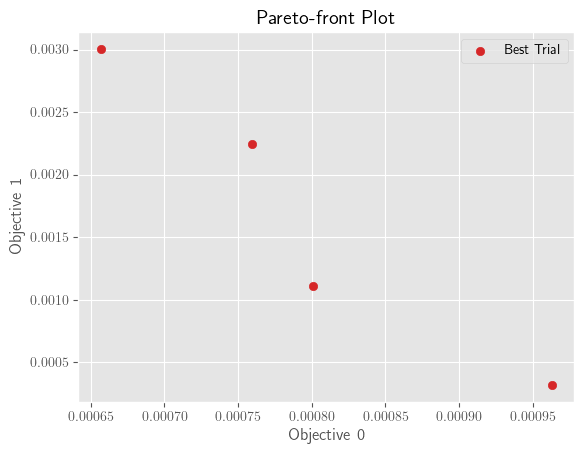

In [84]:
optuna.visualization.matplotlib.plot_pareto_front(opt_trial.study, include_dominated_trials=False)
#plt.xscale('log')
#plt.yscale('log')
#plt.scatter(*attribs_focus.values(), color='green')

In [85]:
joblib.dump(opt_trial.study.trials, 
            save_dir /"trials.joblib", compress=4)

['/Users/skandel/code/oasys/AI-ML_Control_System/work_directory/28-ID/jupyter/sims_for_paper/beamline34/nf_fwhm_pl_one_step_100/trials.joblib']

#### This is the analysis part

In [86]:
hist_dir = Path(save_dir)
hist_dir.exists()

True

In [87]:
trials_file = save_dir / "trials.joblib"

In [88]:
study = analysis.create_study_from_trials(trials_file, n_objectives=2)
n_steps = len(study.trials)

[I 2023-07-05 00:06:59,019] A new study created in memory with name: no-name-e4f923b3-16ba-4e13-98a2-e708279311a3


Assuming minimization for all objectives.


In [89]:
hists = analysis.load_histograms_from_files(n_steps, hist_dir, extension='gz')

In [90]:
nash_trial, nash_idx, n_doms = analysis.select_nash_equil_trial_from_pareto_front(study)

Trial number 54
Trial values: peak_distance 3.005e-03 fwhm 6.569e-04
Trial dw:
{'h_sigma': 0.0025744347072776527, 'h_fwhm': 0.0004882812500000416, 'h_centroid': 0.0027801115041295684, 'h_peak': 0.003002929687500001, 'v_sigma': 0.0011841157711901063, 'v_fwhm': 0.00043945312500003747, 'v_centroid': -0.0006170239039691499, 'v_peak': -0.0001220703125, 'integral_intensity': 8333.140722431954, 'peak_intensity': 32.43756860901457, 'gaussian_fit': {}}
Actual fwhm 0.000656915236673577


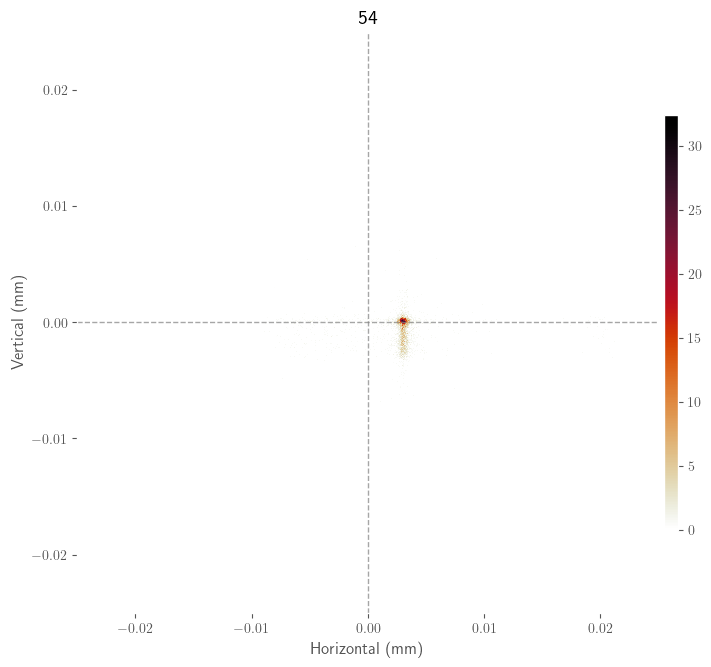

Trial number 66
Trial values: peak_distance 3.183e-04 fwhm 9.630e-04
Trial dw:
{'h_sigma': 0.0010385986707261022, 'h_fwhm': 0.0008300781250000708, 'h_centroid': 0.00011638943735483757, 'h_peak': -0.00017089843749999896, 'v_sigma': 0.0007743505217102231, 'v_fwhm': 0.0004882812500000416, 'v_centroid': 6.592981092017497e-05, 'v_peak': -0.00026855468750000035, 'integral_intensity': 8337.00601233823, 'peak_intensity': 27.32287442599546, 'gaussian_fit': {}}
Actual fwhm 0.0009630411583651221


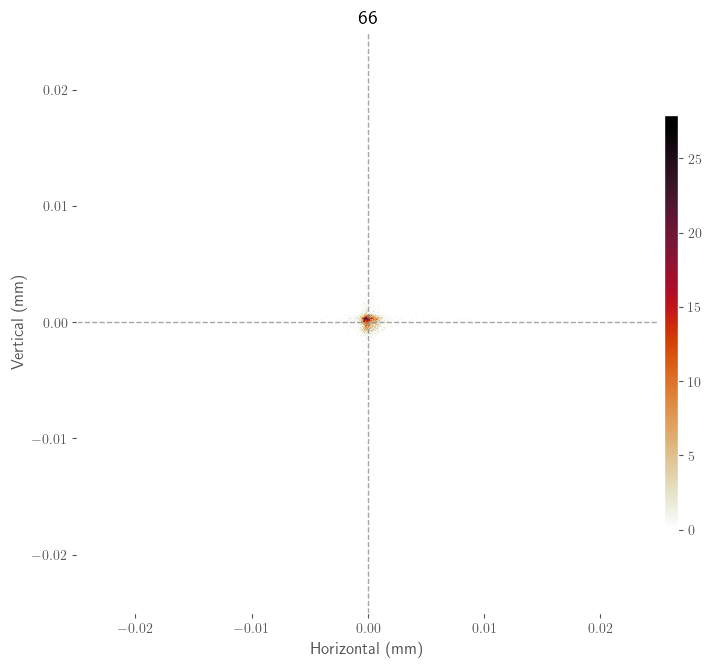

Trial number 100
Trial values: peak_distance 1.105e-03 fwhm 8.008e-04
Trial dw:
{'h_sigma': 0.0010785744729796371, 'h_fwhm': 0.0006347656250000541, 'h_centroid': 0.0011732825061070845, 'h_peak': 0.0010986328125, 'v_sigma': 0.0011204930540839708, 'v_fwhm': 0.0004882812500000416, 'v_centroid': 0.0002628823244882265, 'v_peak': -0.0001220703125, 'integral_intensity': 8331.704432332934, 'peak_intensity': 35.259605688583605, 'gaussian_fit': {}}
Actual fwhm 0.0008008407942801818


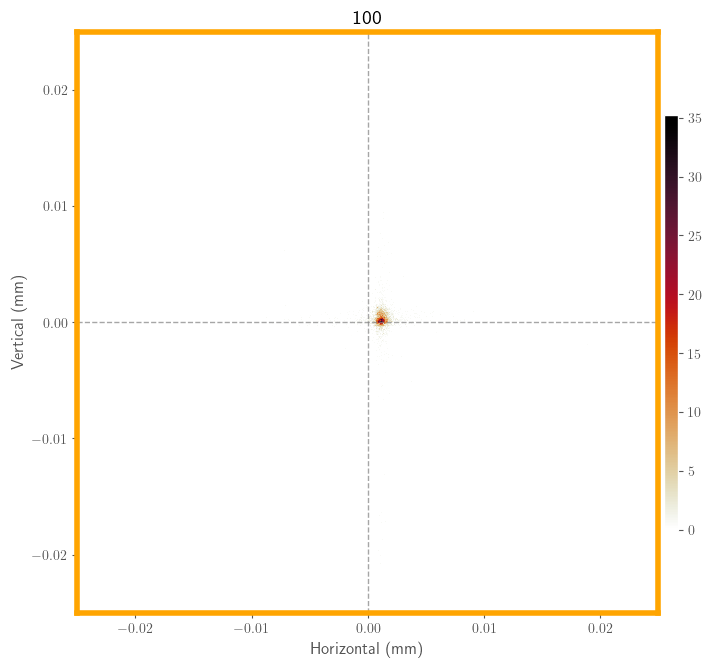

Trial number 117
Trial values: peak_distance 2.244e-03 fwhm 7.596e-04
Trial dw:
{'h_sigma': 0.0010878916154099417, 'h_fwhm': 0.0005371093750000458, 'h_centroid': 0.0010124453275445833, 'h_peak': 0.000561523437500001, 'v_sigma': 0.0010824604004694952, 'v_fwhm': 0.0005371093750000458, 'v_centroid': -0.002271312310648322, 'v_peak': 0.0021728515624999997, 'integral_intensity': 8338.166219450899, 'peak_intensity': 30.533539079820148, 'gaussian_fit': {}}
Actual fwhm 0.0007595873626028013


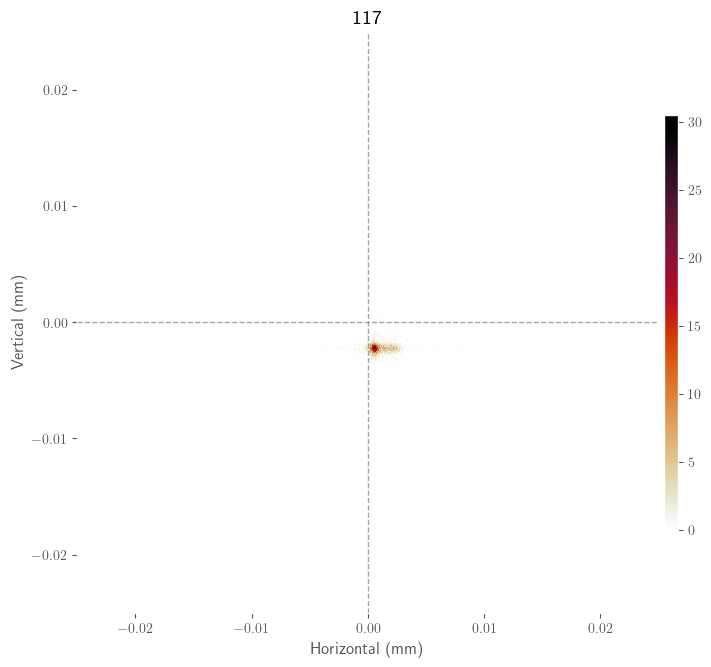

In [91]:
best_hists = []
for t in study.best_trials:
    print("Trial number", t.number)
    print(f"Trial values: peak_distance {t.values[1]:4.3e} fwhm {t.values[0]:4.3e}")
    print("Trial dw:")
    
    dw = dict(t.user_attrs["dw"]._DictionaryWrapper__dictionary)
    print(dw)
    print("Actual fwhm", opt_common._get_fwhm_from_dw(t.user_attrs["dw"]))
    hist = hists[t.number]
    plt.figure(figsize=[7,7], constrained_layout=True)
    plt.pcolormesh(hist.hh, hist.vv, hist.data_2D.T, cmap=m2)#, norm=mpl.colors.LogNorm(1, 4e2))
    #plt.xlim(-0.04,0.04)
    #plt.ylim(-0.04,0.04)
    plt.axhline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
    plt.axvline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
    plt.xlabel('Horizontal (mm)')
    plt.ylabel('Vertical (mm)')
    plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

    ax = plt.gca()
    ax.set_aspect('equal')
    if t.number == nash_trial.number:
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(4)
            ax.spines[axis].set_color('orange')

    plt.title(t.number)
    plt.show()